## Лабораторная работа №2. 
**Выполнил Андрей Носков**

In [1]:
import pandas as pd
import json
import re
import string
import pymorphy2
from scipy.sparse import *
import stop_words
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from matplotlib.pylab import rc, plot
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

# 1. Предобработка текстов

In [3]:
EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0'])

In [4]:
GRAMMS = ['NOUN', 'ADJF', 'ADJS', 'PRTF', 'PRTS', 'GRND', 'ADVB']

In [5]:
DATA_PATH = 'life_news.json'

In [6]:
news = []
with open(DATA_PATH) as file:
    for line in file:
        news.append(json.loads(line))
data = pd.DataFrame(news)
data

,link,title,category,tags,text
0,https://life.ru/p/1468875,Волновое оружие России или теория заговора: Чт...,tehnologii,"[Военная техника, Интересное, Наука и Технолог...",Признаки нездорового поведения американские ди...
1,https://life.ru/p/1468946,Струны Вселенной: Учёные рассмотрели загадочны...,tehnologii,"[Вселенная, Наука и Технологии, Статьи, Вселен...","Итак, что мы видим в небе Северного полушария ..."
2,https://life.ru/p/1468173,Геомагнитный нокдаун: Учёные нашли под Гренлан...,tehnologii,"[солнечнаясистема, землетрясения, Вселенная, Н...",Недавно опубликованное исследование учёных Лун...
3,https://life.ru/p/1468421,"Стабильная нестабильность: 7 скрытых причин, п...",tehnologii,"[whatsapp, программы, Смартфоны, телефоны, про...",Мир Android заметно сложнее для рядового польз...
4,https://life.ru/p/1469191,Минобороны показало видео патрулирования росси...,tehnologii,"[бомбардировщики, вксрф, Белоруссия, Военная т...",Минобороны РФ показало видео патрулирования бо...
...,...,...,...,...,...
4753,https://life.ru/p/1461698,Двое рабочих погибли в результате взрыва на за...,proisshestviya,"[Происшествия, Ставропольский край, Новости, П...",Двое рабочих погибли в результате взрыва балло...
4754,https://life.ru/p/1461688,Число пострадавших в ДТП с автобусом в Воронеж...,proisshestviya,"[ДТП, Происшествия, Воронежская область, Новос...",В результате ДТП с маршрутным автобусом в Воро...
4755,https://life.ru/p/1461684,Во Франции произошла утечка углеводородов с за...,proisshestviya,"[Франция, Происшествия, В мире, Новости, Франц...",На юге Франции в канале Марсель – Рона было об...
4756,https://life.ru/p/1461681,На помощь терпящему бедствие в Охотском море с...,proisshestviya,"[охотскоеморе, Происшествия, Хабаровский край,...","Для спасения экипажа грузового судна ""Григорий..."


In [7]:
corpus, texts = [], []

for message in log_progress(data.text.dropna().values):
    sp = message.split('\n')
    corpus += sp
    texts += sp
print(len(corpus), len(texts))

4758 4758


In [8]:
print(corpus[2345])
print(len(corpus[2345]))

Стали известны судьи финального выпуска шоу "Ледниковый период", который выходит на Первом канале. Об этом передаёт радио "Комсомольская правда".   Места в судейской коллегии заняли чемпионка Олимпиады в танцах на льду Татьяна Навка, двукратный олимпийский чемпион в парном катании Максим Траньков и бронзовый и серебряный призёр Олимпийских игр Александр Жулин. Кроме того, вместо Татьяны Тарасовой зрители финального выпуска передачи увидят певца Филиппа Киркорова и телеведущую Аллу Михееву.   Ранее Лайф писал, что Милохин и Медведева завершили номер на проекте "Ледниковый период" долгим поцелуем. До этого фигуристка заявляла, что её с Даней связывают только дружеские отношения.   
688


In [9]:
init_cnt = 0
for doc in corpus:
    init_cnt += len(doc)
print(init_cnt)

6455521


In [10]:
corpus = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', u'', doc) for doc in corpus]
corpus = [re.sub(' +' , ' ', doc) for doc in corpus]

In [11]:
corpus = np.asarray([doc.strip().strip('\t').replace('\n', u'') for doc in corpus])

<b>Удалим следующие символы из текстов: знаки пунктуации, смайлики (эмодзи), числа и другие символы, которые могут являться шумом в тексте:</b>

In [12]:
print(string.punctuation, string.digits, EXCLUDE_SYMBOLS_STR, string.printable, string.whitespace)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 0123456789 №«ђ°±‚ћ‰…»ѓµ·ґњїџє‹‡†¶ќ€“ў§„”﻿’љ›•—‘­¤  0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	
  	



In [13]:
regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
regex_dig = re.compile('[%s]' % re.escape(string.digits))
regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
regex_struct = re.compile('[%s]' % string.printable + string.whitespace)
emoji_pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"
                       u"\U0001F300-\U0001F5FF"
                       u"\U0001F680-\U0001F6FF"
                       u"\U0001F1E0-\U0001F1FF"
                       u"\U00002500-\U00002BEF"
                       u"\U00002702-\U000027B0"
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       u"\U0001f926-\U0001f937"
                       u"\U00010000-\U0010ffff"
                       u"\u2640-\u2642"
                       u"\u2600-\u2B55"
                       u"\u200d"
                       u"\u23cf"
                       u"\u23e9"
                       u"\u231a"
                       u"\ufe0f"
                       u"\u3030"
                       "]+", flags=re.UNICODE)

In [14]:
corpus = [regex_punct.sub('', doc) for doc in corpus]
corpus = [regex_dig.sub('', doc) for doc in corpus]
corpus = [regex_symb.sub(' ', doc) for doc in corpus]
corpus = [regex_struct.sub('', doc) for doc in corpus]
corpus = [emoji_pattern.sub('', doc) for doc in corpus]
corpus = [re.sub(' +' , ' ', doc.strip()) for doc in corpus]
print(len(corpus))

4758


Также удаляем все ссылки:

In [15]:
corpus = [re.sub('<.*?>+', '', doc) for doc in corpus]
corpus = [re.sub(r'http\s+|www.\s+', '', doc) for doc in corpus]
corpus = [re.sub(r'www.\S+', '', doc) for doc in corpus]
corpus = [re.sub(r'http\S+', '', doc) for doc in corpus]

In [16]:
cnt = 0
for doc in corpus:
    cnt += len(doc)
print(cnt)

6140443


**Таким образом, после удаления ненужных символов, их общее количество уменьшилось на :**

In [17]:
print(init_cnt - cnt)

315078


**Но на этом предобработка исходных текстов не закончена. <b>Произведем лемматизацию</b>, что приведет большинство слов к канонической форме, или к так называемым леммам**

In [18]:
 morph = pymorphy2.MorphAnalyzer()

In [19]:
def lemmatize_text(text):
    new_text = str()
    for word in text.split(' '):
        new_word = morph.parse(word)[0].normal_form
        new_text += new_word + ' '
    new_text = new_text[:-1]
    return new_text

In [20]:
corpus = list(map(lemmatize_text, corpus))

**Теперь нужно произвести удаление стоп-слов**:

In [21]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [22]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
stop = stopwords.words('russian')
stop[:10]

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [24]:
corpus = list(map(lambda x: ' '.join([word for word in x.split() if word not in (stop)]), corpus))

In [25]:
corpus[2345]

'стать известный судья финальный выпуск шоу ледниковый период который выходить первый канал это передавать радио комсомольский правда место судейский коллегия занять чемпионка олимпиада танец лёд татьяна навка двукратный олимпийский чемпион парный катание максим траньковы бронзовый серебряный призёр олимпийский игра александр жулин кроме вместо татьяна тарасов зритель финальный выпуск передача увидеть певец филипп киркоров телеведущий алла михеев ранее лайф писать милохина медведев завершить номер проект ледниковый период долгий поцелуй это фигуристка заявлять её дань связывать дружеский отношение'

# Векторизация текстов
**для векторизации был выбран алгоритм, основанный на TF-IDF мере, поскольку в она дает возможность регулизации получаемых численных значений слов для часто встречаемых во всех текстах(их вес будет не таким значимым, как для редких слов)**

In [26]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

In [27]:
X.get_shape()

(4758, 33395)

In [28]:
Y = data['category']
Y

0           tehnologii
1           tehnologii
2           tehnologii
3           tehnologii
4           tehnologii
             ...      
4753    proisshestviya
4754    proisshestviya
4755    proisshestviya
4756    proisshestviya
4757    proisshestviya
Name: category, Length: 4758, dtype: object

In [29]:
vectorizer.get_feature_names()

['aad',
 'aartykru',
 'ab',
 'abc',
 'abcjpegexe',
 'abf',
 'ability',
 'abn',
 'abortсистема',
 'abrams',
 'abs',
 'academi',
 'acceleration',
 'accenture',
 'accuracy',
 'ace',
 'acer',
 'acidophilium',
 'acs',
 'acta',
 'action',
 'active',
 'activision',
 'actmobile',
 'adam',
 'addiction',
 'addictive',
 'adelaide',
 'adnoc',
 'adp',
 'adrennealine',
 'adria',
 'advanced',
 'advances',
 'advancing',
 'adventure',
 'advisory',
 'ae',
 'aegis',
 'aerojet',
 'aerospace',
 'af',
 'affairs',
 'afp',
 'africa',
 'ag',
 'against',
 'age',
 'agence',
 'agile',
 'agma',
 'ahi',
 'ai',
 'aim',
 'air',
 'airbus',
 'airi',
 'airlines',
 'airpods',
 'airshow',
 'airways',
 'ajansi',
 'ajansspor',
 'ajax',
 'ajeya',
 'akinci',
 'aksam',
 'al',
 'alegria',
 'alen',
 'alert',
 'alexcapetown',
 'algo',
 'algorithms',
 'alibaba',
 'aliexpress',
 'aliexpressроссия',
 'all',
 'allgemeine',
 'alliance',
 'alma',
 'almera',
 'almuntazah',
 'along',
 'alphabet',
 'alsheimer',
 'alsi',
 'alsimgmn',
 'alt

**По словарю TF-IDF видно, что в текстах присутствуют слова на английском языке. Оставим их, т.к. неизвестно, положительно или отрицательно повлияет удаление на результаты классификации. Осталось разбить выборку на тренировочную и тестовую**

In [30]:
enc = OneHotEncoder()
Y_lbl = enc.fit_transform(np.array(Y).reshape(-1, 1))
Y_lbl.toarray()

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=42)

In [32]:
_, _, y_train_lbl, y_test_lbl = train_test_split(X, Y_lbl, test_size=0.35, random_state=42)

# Классификация
## 1. Logistic Regression
**<i>В качестве первого классификатора было принято решение взять Логистическую регрессию. Гипер-параметрами здесь являются солвер, которым будет решаться задача оптимизации функции ММП, а так же коэффициент регуляризации (Я оставил только l2-регуляризацию, т.к. с ней работают все солверы)</i>**

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV

In [39]:
decision_param = {
    "C" : [0.01, 0.1, 1, 10, 100, 1000, 1e4],
    "penalty" : ["l2"], 
    "multi_class" : ["auto"],
    "solver" : ["lbfgs", "sag", "saga", "liblinear", "newton-cg"],
}

log_reg_grid = GridSearchCV(estimator=LogisticRegression(), param_grid=decision_param, 
                           cv=5, verbose=3, scoring='f1_macro')
log_reg_grid.fit(X_train, y_train)
y_pred_lr = log_reg_grid.predict(X_test)
y_prob_lr = log_reg_grid.predict_proba(X_test)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV] C=0.01, multi_class=auto, penalty=l2, solver=lbfgs ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.01, multi_class=auto, penalty=l2, solver=lbfgs, score=0.904, total=   0.8s
[CV] C=0.01, multi_class=auto, penalty=l2, solver=lbfgs ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  C=0.01, multi_class=auto, penalty=l2, solver=lbfgs, score=0.879, total=   0.7s
[CV] C=0.01, multi_class=auto, penalty=l2, solver=lbfgs ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV]  C=0.01, multi_class=auto, penalty=l2, solver=lbfgs, score=0.895, total=   0.6s
[CV] C=0.01, multi_class=auto, penalty=l2, solver=lbfgs ..............
[CV]  C=0.01, multi_class=auto, penalty=l2, solver=lbfgs, score=0.897, total=   0.6s
[CV] C=0.01, multi_class=auto, penalty=l2, solver=lbfgs ..............
[CV]  C=0.01, multi_class=auto, penalty=l2, solver=lbfgs, score=0.883, total=   0.5s
[CV] C=0.01, multi_class=auto, penalty=l2, solver=sag ................
[CV]  C=0.01, multi_class=auto, penalty=l2, solver=sag, score=0.904, total=   0.3s
[CV] C=0.01, multi_class=auto, penalty=l2, solver=sag ................
[CV]  C=0.01, multi_class=auto, penalty=l2, solver=sag, score=0.880, total=   0.3s
[CV] C=0.01, multi_class=auto, penalty=l2, solver=sag ................
[CV]  C=0.01, multi_class=auto, penalty=l2, solver=sag, score=0.895, total=   0.2s
[CV] C=0.01, multi_class=auto, penalty=l2, solver=sag ................
[CV]  C=0.01, multi_class=auto, penalty=l2, solver=sag, score=0.897, t

[CV]  C=1, multi_class=auto, penalty=l2, solver=sag, score=0.953, total=   0.1s
[CV] C=1, multi_class=auto, penalty=l2, solver=sag ...................
[CV]  C=1, multi_class=auto, penalty=l2, solver=sag, score=0.956, total=   0.1s
[CV] C=1, multi_class=auto, penalty=l2, solver=sag ...................
[CV]  C=1, multi_class=auto, penalty=l2, solver=sag, score=0.942, total=   0.1s
[CV] C=1, multi_class=auto, penalty=l2, solver=sag ...................
[CV]  C=1, multi_class=auto, penalty=l2, solver=sag, score=0.942, total=   0.1s
[CV] C=1, multi_class=auto, penalty=l2, solver=saga ..................
[CV]  C=1, multi_class=auto, penalty=l2, solver=saga, score=0.955, total=   0.2s
[CV] C=1, multi_class=auto, penalty=l2, solver=saga ..................
[CV]  C=1, multi_class=auto, penalty=l2, solver=saga, score=0.955, total=   0.3s
[CV] C=1, multi_class=auto, penalty=l2, solver=saga ..................
[CV]  C=1, multi_class=auto, penalty=l2, solver=saga, score=0.956, total=   0.2s
[CV] C=1, m

C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  C=10, multi_class=auto, penalty=l2, solver=lbfgs, score=0.956, total=   1.9s
[CV] C=10, multi_class=auto, penalty=l2, solver=lbfgs ................
[CV]  C=10, multi_class=auto, penalty=l2, solver=lbfgs, score=0.958, total=   1.8s
[CV] C=10, multi_class=auto, penalty=l2, solver=lbfgs ................
[CV]  C=10, multi_class=auto, penalty=l2, solver=lbfgs, score=0.960, total=   1.9s
[CV] C=10, multi_class=auto, penalty=l2, solver=lbfgs ................


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  C=10, multi_class=auto, penalty=l2, solver=lbfgs, score=0.948, total=   1.9s
[CV] C=10, multi_class=auto, penalty=l2, solver=lbfgs ................


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  C=10, multi_class=auto, penalty=l2, solver=lbfgs, score=0.947, total=   1.9s
[CV] C=10, multi_class=auto, penalty=l2, solver=sag ..................
[CV]  C=10, multi_class=auto, penalty=l2, solver=sag, score=0.956, total=   0.4s
[CV] C=10, multi_class=auto, penalty=l2, solver=sag ..................
[CV]  C=10, multi_class=auto, penalty=l2, solver=sag, score=0.958, total=   0.4s
[CV] C=10, multi_class=auto, penalty=l2, solver=sag ..................
[CV]  C=10, multi_class=auto, penalty=l2, solver=sag, score=0.960, total=   0.4s
[CV] C=10, multi_class=auto, penalty=l2, solver=sag ..................
[CV]  C=10, multi_class=auto, penalty=l2, solver=sag, score=0.948, total=   0.4s
[CV] C=10, multi_class=auto, penalty=l2, solver=sag ..................
[CV]  C=10, multi_class=auto, penalty=l2, solver=sag, score=0.947, total=   0.4s
[CV] C=10, multi_class=auto, penalty=l2, solver=saga .................


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=10, multi_class=auto, penalty=l2, solver=saga, score=0.956, total=   0.9s
[CV] C=10, multi_class=auto, penalty=l2, solver=saga .................
[CV]  C=10, multi_class=auto, penalty=l2, solver=saga, score=0.958, total=   0.6s
[CV] C=10, multi_class=auto, penalty=l2, solver=saga .................


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=10, multi_class=auto, penalty=l2, solver=saga, score=0.961, total=   0.9s
[CV] C=10, multi_class=auto, penalty=l2, solver=saga .................


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=10, multi_class=auto, penalty=l2, solver=saga, score=0.947, total=   0.9s
[CV] C=10, multi_class=auto, penalty=l2, solver=saga .................
[CV]  C=10, multi_class=auto, penalty=l2, solver=saga, score=0.947, total=   0.5s
[CV] C=10, multi_class=auto, penalty=l2, solver=liblinear ............
[CV]  C=10, multi_class=auto, penalty=l2, solver=liblinear, score=0.960, total=   0.2s
[CV] C=10, multi_class=auto, penalty=l2, solver=liblinear ............
[CV]  C=10, multi_class=auto, penalty=l2, solver=liblinear, score=0.960, total=   0.1s
[CV] C=10, multi_class=auto, penalty=l2, solver=liblinear ............
[CV]  C=10, multi_class=auto, penalty=l2, solver=liblinear, score=0.964, total=   0.1s
[CV] C=10, multi_class=auto, penalty=l2, solver=liblinear ............
[CV]  C=10, multi_class=auto, penalty=l2, solver=liblinear, score=0.948, total=   0.1s
[CV] C=10, multi_class=auto, penalty=l2, solver=liblinear ............
[CV]  C=10, multi_class=auto, penalty=l2, solver=liblinear, sc

C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  C=100, multi_class=auto, penalty=l2, solver=lbfgs, score=0.964, total=   1.9s
[CV] C=100, multi_class=auto, penalty=l2, solver=lbfgs ...............


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  C=100, multi_class=auto, penalty=l2, solver=lbfgs, score=0.963, total=   2.0s
[CV] C=100, multi_class=auto, penalty=l2, solver=lbfgs ...............


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  C=100, multi_class=auto, penalty=l2, solver=lbfgs, score=0.964, total=   2.0s
[CV] C=100, multi_class=auto, penalty=l2, solver=lbfgs ...............


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  C=100, multi_class=auto, penalty=l2, solver=lbfgs, score=0.943, total=   1.9s
[CV] C=100, multi_class=auto, penalty=l2, solver=lbfgs ...............


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  C=100, multi_class=auto, penalty=l2, solver=lbfgs, score=0.947, total=   1.9s
[CV] C=100, multi_class=auto, penalty=l2, solver=sag .................


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=100, multi_class=auto, penalty=l2, solver=sag, score=0.961, total=   0.7s
[CV] C=100, multi_class=auto, penalty=l2, solver=sag .................


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=100, multi_class=auto, penalty=l2, solver=sag, score=0.961, total=   0.7s
[CV] C=100, multi_class=auto, penalty=l2, solver=sag .................


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=100, multi_class=auto, penalty=l2, solver=sag, score=0.966, total=   0.7s
[CV] C=100, multi_class=auto, penalty=l2, solver=sag .................


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=100, multi_class=auto, penalty=l2, solver=sag, score=0.943, total=   0.7s
[CV] C=100, multi_class=auto, penalty=l2, solver=sag .................


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=100, multi_class=auto, penalty=l2, solver=sag, score=0.947, total=   0.8s
[CV] C=100, multi_class=auto, penalty=l2, solver=saga ................


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=100, multi_class=auto, penalty=l2, solver=saga, score=0.964, total=   1.0s
[CV] C=100, multi_class=auto, penalty=l2, solver=saga ................


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=100, multi_class=auto, penalty=l2, solver=saga, score=0.961, total=   1.0s
[CV] C=100, multi_class=auto, penalty=l2, solver=saga ................


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=100, multi_class=auto, penalty=l2, solver=saga, score=0.966, total=   0.9s
[CV] C=100, multi_class=auto, penalty=l2, solver=saga ................


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=100, multi_class=auto, penalty=l2, solver=saga, score=0.945, total=   0.9s
[CV] C=100, multi_class=auto, penalty=l2, solver=saga ................


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=100, multi_class=auto, penalty=l2, solver=saga, score=0.947, total=   0.9s
[CV] C=100, multi_class=auto, penalty=l2, solver=liblinear ...........
[CV]  C=100, multi_class=auto, penalty=l2, solver=liblinear, score=0.963, total=   0.2s
[CV] C=100, multi_class=auto, penalty=l2, solver=liblinear ...........
[CV]  C=100, multi_class=auto, penalty=l2, solver=liblinear, score=0.963, total=   0.2s
[CV] C=100, multi_class=auto, penalty=l2, solver=liblinear ...........
[CV]  C=100, multi_class=auto, penalty=l2, solver=liblinear, score=0.963, total=   0.1s
[CV] C=100, multi_class=auto, penalty=l2, solver=liblinear ...........
[CV]  C=100, multi_class=auto, penalty=l2, solver=liblinear, score=0.943, total=   0.2s
[CV] C=100, multi_class=auto, penalty=l2, solver=liblinear ...........
[CV]  C=100, multi_class=auto, penalty=l2, solver=liblinear, score=0.948, total=   0.2s
[CV] C=100, multi_class=auto, penalty=l2, solver=newton-cg ...........
[CV]  C=100, multi_class=auto, penalty=l2, solver=n

C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  C=1000, multi_class=auto, penalty=l2, solver=lbfgs, score=0.963, total=   2.0s
[CV] C=1000, multi_class=auto, penalty=l2, solver=lbfgs ..............


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  C=1000, multi_class=auto, penalty=l2, solver=lbfgs, score=0.963, total=   1.9s
[CV] C=1000, multi_class=auto, penalty=l2, solver=lbfgs ..............


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  C=1000, multi_class=auto, penalty=l2, solver=lbfgs, score=0.964, total=   2.0s
[CV] C=1000, multi_class=auto, penalty=l2, solver=lbfgs ..............


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  C=1000, multi_class=auto, penalty=l2, solver=lbfgs, score=0.942, total=   1.9s
[CV] C=1000, multi_class=auto, penalty=l2, solver=lbfgs ..............


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  C=1000, multi_class=auto, penalty=l2, solver=lbfgs, score=0.947, total=   1.9s
[CV] C=1000, multi_class=auto, penalty=l2, solver=sag ................


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=1000, multi_class=auto, penalty=l2, solver=sag, score=0.966, total=   0.7s
[CV] C=1000, multi_class=auto, penalty=l2, solver=sag ................


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=1000, multi_class=auto, penalty=l2, solver=sag, score=0.965, total=   0.7s
[CV] C=1000, multi_class=auto, penalty=l2, solver=sag ................


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=1000, multi_class=auto, penalty=l2, solver=sag, score=0.960, total=   0.7s
[CV] C=1000, multi_class=auto, penalty=l2, solver=sag ................


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=1000, multi_class=auto, penalty=l2, solver=sag, score=0.950, total=   0.7s
[CV] C=1000, multi_class=auto, penalty=l2, solver=sag ................


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=1000, multi_class=auto, penalty=l2, solver=sag, score=0.947, total=   0.7s
[CV] C=1000, multi_class=auto, penalty=l2, solver=saga ...............


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=1000, multi_class=auto, penalty=l2, solver=saga, score=0.963, total=   0.9s
[CV] C=1000, multi_class=auto, penalty=l2, solver=saga ...............


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=1000, multi_class=auto, penalty=l2, solver=saga, score=0.958, total=   1.0s
[CV] C=1000, multi_class=auto, penalty=l2, solver=saga ...............


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=1000, multi_class=auto, penalty=l2, solver=saga, score=0.966, total=   0.9s
[CV] C=1000, multi_class=auto, penalty=l2, solver=saga ...............


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=1000, multi_class=auto, penalty=l2, solver=saga, score=0.945, total=   0.9s
[CV] C=1000, multi_class=auto, penalty=l2, solver=saga ...............


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=1000, multi_class=auto, penalty=l2, solver=saga, score=0.948, total=   0.9s
[CV] C=1000, multi_class=auto, penalty=l2, solver=liblinear ..........
[CV]  C=1000, multi_class=auto, penalty=l2, solver=liblinear, score=0.960, total=   0.2s
[CV] C=1000, multi_class=auto, penalty=l2, solver=liblinear ..........
[CV]  C=1000, multi_class=auto, penalty=l2, solver=liblinear, score=0.965, total=   0.2s
[CV] C=1000, multi_class=auto, penalty=l2, solver=liblinear ..........
[CV]  C=1000, multi_class=auto, penalty=l2, solver=liblinear, score=0.964, total=   0.2s
[CV] C=1000, multi_class=auto, penalty=l2, solver=liblinear ..........
[CV]  C=1000, multi_class=auto, penalty=l2, solver=liblinear, score=0.943, total=   0.2s
[CV] C=1000, multi_class=auto, penalty=l2, solver=liblinear ..........
[CV]  C=1000, multi_class=auto, penalty=l2, solver=liblinear, score=0.947, total=   0.2s
[CV] C=1000, multi_class=auto, penalty=l2, solver=newton-cg ..........
[CV]  C=1000, multi_class=auto, penalty=l2, s

C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  C=10000.0, multi_class=auto, penalty=l2, solver=lbfgs, score=0.961, total=   1.9s
[CV] C=10000.0, multi_class=auto, penalty=l2, solver=lbfgs ...........


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  C=10000.0, multi_class=auto, penalty=l2, solver=lbfgs, score=0.965, total=   2.0s
[CV] C=10000.0, multi_class=auto, penalty=l2, solver=lbfgs ...........


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  C=10000.0, multi_class=auto, penalty=l2, solver=lbfgs, score=0.963, total=   1.9s
[CV] C=10000.0, multi_class=auto, penalty=l2, solver=lbfgs ...........


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  C=10000.0, multi_class=auto, penalty=l2, solver=lbfgs, score=0.943, total=   1.9s
[CV] C=10000.0, multi_class=auto, penalty=l2, solver=lbfgs ...........


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  C=10000.0, multi_class=auto, penalty=l2, solver=lbfgs, score=0.947, total=   1.9s
[CV] C=10000.0, multi_class=auto, penalty=l2, solver=sag .............


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=10000.0, multi_class=auto, penalty=l2, solver=sag, score=0.963, total=   0.7s
[CV] C=10000.0, multi_class=auto, penalty=l2, solver=sag .............


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=10000.0, multi_class=auto, penalty=l2, solver=sag, score=0.963, total=   0.8s
[CV] C=10000.0, multi_class=auto, penalty=l2, solver=sag .............


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=10000.0, multi_class=auto, penalty=l2, solver=sag, score=0.964, total=   0.7s
[CV] C=10000.0, multi_class=auto, penalty=l2, solver=sag .............


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=10000.0, multi_class=auto, penalty=l2, solver=sag, score=0.948, total=   0.8s
[CV] C=10000.0, multi_class=auto, penalty=l2, solver=sag .............


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=10000.0, multi_class=auto, penalty=l2, solver=sag, score=0.945, total=   0.7s
[CV] C=10000.0, multi_class=auto, penalty=l2, solver=saga ............


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=10000.0, multi_class=auto, penalty=l2, solver=saga, score=0.961, total=   1.0s
[CV] C=10000.0, multi_class=auto, penalty=l2, solver=saga ............


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=10000.0, multi_class=auto, penalty=l2, solver=saga, score=0.963, total=   0.9s
[CV] C=10000.0, multi_class=auto, penalty=l2, solver=saga ............


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=10000.0, multi_class=auto, penalty=l2, solver=saga, score=0.963, total=   0.9s
[CV] C=10000.0, multi_class=auto, penalty=l2, solver=saga ............


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=10000.0, multi_class=auto, penalty=l2, solver=saga, score=0.945, total=   0.9s
[CV] C=10000.0, multi_class=auto, penalty=l2, solver=saga ............


C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=10000.0, multi_class=auto, penalty=l2, solver=saga, score=0.948, total=   0.9s
[CV] C=10000.0, multi_class=auto, penalty=l2, solver=liblinear .......
[CV]  C=10000.0, multi_class=auto, penalty=l2, solver=liblinear, score=0.960, total=   0.2s
[CV] C=10000.0, multi_class=auto, penalty=l2, solver=liblinear .......
[CV]  C=10000.0, multi_class=auto, penalty=l2, solver=liblinear, score=0.965, total=   0.2s
[CV] C=10000.0, multi_class=auto, penalty=l2, solver=liblinear .......
[CV]  C=10000.0, multi_class=auto, penalty=l2, solver=liblinear, score=0.963, total=   0.2s
[CV] C=10000.0, multi_class=auto, penalty=l2, solver=liblinear .......
[CV]  C=10000.0, multi_class=auto, penalty=l2, solver=liblinear, score=0.943, total=   0.2s
[CV] C=10000.0, multi_class=auto, penalty=l2, solver=liblinear .......
[CV]  C=10000.0, multi_class=auto, penalty=l2, solver=liblinear, score=0.947, total=   0.2s
[CV] C=10000.0, multi_class=auto, penalty=l2, solver=newton-cg .......
[CV]  C=10000.0, multi_clas

[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  2.0min finished
C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


**<i>Теперь возьмем наилучшие параметры, и обучим на них регрессию, после чего рассмотрим различные метрики</i>**

In [42]:
log_reg_grid.best_params_

{'C': 1000, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'sag'}

In [36]:
log_reg = LogisticRegression(C=1000, penalty="l2", solver='sag', multi_class='auto')
log_reg.fit(X_train, y_train)

C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(C=1000, solver='sag')

In [37]:
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)

In [38]:
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr, average='macro'))
print("Precision:", precision_score(y_test, y_pred_lr, average='macro'))
print("F1:", f1_score(y_test, y_pred_lr, average='macro'))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr, average='macro', multi_class='ovr'))

Accuracy: 0.9603841536614646
Recall: 0.960288160654919
Precision: 0.9602718605930942
F1: 0.9602751999903013
ROC AUC: 0.994257037634533


<b><i>Визуализировать полученную Логисчитческую регрессию будет неудобно, т.к. вектор каждого предложения содержит, как было указано выше, 33395 признаков. Поэтому буду основываться на полученных метриках :</i></b>

<ul>
    <li>В целом метрики  Precision и Recall оказались довольно близкими, что говорит о том, что False Positive & False Negative предсказания примерно одинаковы и близки к нулю</li>
    <li>Исходя из этого, F-1 score тоже оказался близким к этим метрикам</li>
    <li>Регуляризация была довольно малой (обратный коэф регуляризации С = 1000), но это не поспособствовало переобучению модели, значит параметр был подобран оптимально</li>
    <li><b>Ниже будет приведено сравнение наиболее значимых слов для классов с Методом опорных векторов</b>
</ul>

In [85]:
def show_roc_auc(y_test, y_prob):
    lw = 2
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_test.toarray()[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(4):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= 4

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    # plt.plot(
    #     fpr["micro"],
    #     tpr["micro"],
    #     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    #     color="deeppink",
    #     linestyle=":",
    #     linewidth=4,
    # )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(4), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")

    plt.show()

In [141]:
def get_top_indexes(coefs):
    sorted_indexes = []
    for i in range(len(coefs)):
        values = dict()
        sort = np.argsort(coefs[i])
        for val in sort[-10:]:
            values[val] = coefs[i][val]
        sorted_indexes.append(values)
    return sorted_indexes

In [171]:
def get_top_10_kewords(top_indexes, voc, classes):
    for i in range(len(top_indexes)):
        print(f"Class name: {classes[i]}")
        print("The most important words for this class:", end='')
        for word in top_indexes[i].keys():
            print(f"{list(voc.keys())[list(voc.values()).index(word)]}, ", end='')
        print()
    return

In [182]:
def collect_data(current, y_test, y_predicted, class_name):
    current[class_name] = [accuracy_score(y_test, y_predicted)]
    current[class_name].append(precision_score(y_test, y_predicted, average='macro'))
    current[class_name].append(recall_score(y_test, y_predicted, average='macro'))
    current[class_name].append(f1_score(y_test, y_predicted, average='macro'))
    return current

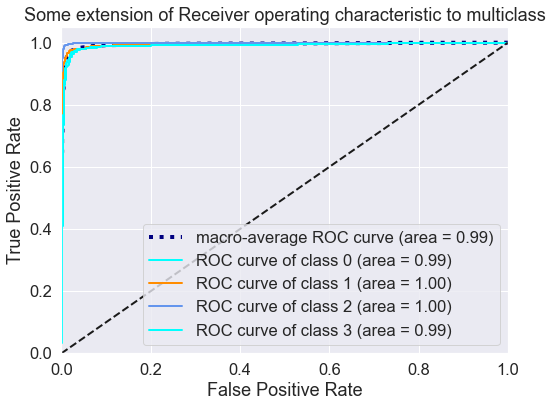

In [151]:
show_roc_auc(y_test_lbl, y_prob_lr)

**<i>Для наглядности визуализировал графики ROC-AUC для каждого из предсказываемых классов текста. Видно, что в левом верхнем углу лишь малая часть текстов оказывалась неправильно предсказываемой, т.е. таких практически нет</i>**

## 2. K Nearest Neighbors
**<i>Аналогично обучим классификатор метода k ближайших соседей. Гиперпараметры - это количество учитываемых соседей и как будет считаться расстояние между двумя векторами предложений</i>**

In [70]:
from sklearn.neighbors import KNeighborsClassifier

In [56]:
decision_param = {
    "n_neighbors" : range(5, 120, 5),
    "weights" : ["uniform", "distance"],
    "p" : [1, 2]    
}
grid_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=decision_param,
                   cv=5, verbose=3, scoring='f1_macro')
grid_knn.fit(X_train, y_train)

Fitting 5 folds for each of 92 candidates, totalling 460 fits
[CV] n_neighbors=5, p=1, weights=uniform .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . n_neighbors=5, p=1, weights=uniform, score=0.567, total=   0.8s
[CV] n_neighbors=5, p=1, weights=uniform .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] . n_neighbors=5, p=1, weights=uniform, score=0.583, total=   0.8s
[CV] n_neighbors=5, p=1, weights=uniform .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV] . n_neighbors=5, p=1, weights=uniform, score=0.619, total=   0.8s
[CV] n_neighbors=5, p=1, weights=uniform .............................
[CV] . n_neighbors=5, p=1, weights=uniform, score=0.592, total=   0.9s
[CV] n_neighbors=5, p=1, weights=uniform .............................
[CV] . n_neighbors=5, p=1, weights=uniform, score=0.597, total=   0.8s
[CV] n_neighbors=5, p=1, weights=distance ............................
[CV]  n_neighbors=5, p=1, weights=distance, score=0.576, total=   0.8s
[CV] n_neighbors=5, p=1, weights=distance ............................
[CV]  n_neighbors=5, p=1, weights=distance, score=0.585, total=   0.8s
[CV] n_neighbors=5, p=1, weights=distance ............................
[CV]  n_neighbors=5, p=1, weights=distance, score=0.626, total=   0.7s
[CV] n_neighbors=5, p=1, weights=distance ............................
[CV]  n_neighbors=5, p=1, weights=distance, score=0.595, total=   0.8s
[CV] n_neighbors=5, p=1, weights=distance ............................
[CV]  

[CV]  n_neighbors=20, p=1, weights=uniform, score=0.398, total=   0.5s
[CV] n_neighbors=20, p=1, weights=uniform ............................
[CV]  n_neighbors=20, p=1, weights=uniform, score=0.375, total=   0.5s
[CV] n_neighbors=20, p=1, weights=uniform ............................
[CV]  n_neighbors=20, p=1, weights=uniform, score=0.466, total=   0.5s
[CV] n_neighbors=20, p=1, weights=uniform ............................
[CV]  n_neighbors=20, p=1, weights=uniform, score=0.394, total=   0.4s
[CV] n_neighbors=20, p=1, weights=uniform ............................
[CV]  n_neighbors=20, p=1, weights=uniform, score=0.428, total=   0.4s
[CV] n_neighbors=20, p=1, weights=distance ...........................
[CV]  n_neighbors=20, p=1, weights=distance, score=0.405, total=   0.4s
[CV] n_neighbors=20, p=1, weights=distance ...........................
[CV]  n_neighbors=20, p=1, weights=distance, score=0.387, total=   0.4s
[CV] n_neighbors=20, p=1, weights=distance ...........................
[CV]

[CV]  n_neighbors=30, p=2, weights=distance, score=0.920, total=   0.1s
[CV] n_neighbors=35, p=1, weights=uniform ............................
[CV]  n_neighbors=35, p=1, weights=uniform, score=0.329, total=   0.5s
[CV] n_neighbors=35, p=1, weights=uniform ............................
[CV]  n_neighbors=35, p=1, weights=uniform, score=0.311, total=   0.5s
[CV] n_neighbors=35, p=1, weights=uniform ............................
[CV]  n_neighbors=35, p=1, weights=uniform, score=0.390, total=   0.5s
[CV] n_neighbors=35, p=1, weights=uniform ............................
[CV]  n_neighbors=35, p=1, weights=uniform, score=0.323, total=   0.5s
[CV] n_neighbors=35, p=1, weights=uniform ............................
[CV]  n_neighbors=35, p=1, weights=uniform, score=0.327, total=   0.5s
[CV] n_neighbors=35, p=1, weights=distance ...........................
[CV]  n_neighbors=35, p=1, weights=distance, score=0.340, total=   0.5s
[CV] n_neighbors=35, p=1, weights=distance ...........................
[CV]

[CV]  n_neighbors=45, p=2, weights=distance, score=0.920, total=   0.1s
[CV] n_neighbors=45, p=2, weights=distance ...........................
[CV]  n_neighbors=45, p=2, weights=distance, score=0.918, total=   0.1s
[CV] n_neighbors=50, p=1, weights=uniform ............................
[CV]  n_neighbors=50, p=1, weights=uniform, score=0.286, total=   0.5s
[CV] n_neighbors=50, p=1, weights=uniform ............................
[CV]  n_neighbors=50, p=1, weights=uniform, score=0.273, total=   0.5s
[CV] n_neighbors=50, p=1, weights=uniform ............................
[CV]  n_neighbors=50, p=1, weights=uniform, score=0.352, total=   0.4s
[CV] n_neighbors=50, p=1, weights=uniform ............................
[CV]  n_neighbors=50, p=1, weights=uniform, score=0.306, total=   0.5s
[CV] n_neighbors=50, p=1, weights=uniform ............................
[CV]  n_neighbors=50, p=1, weights=uniform, score=0.295, total=   0.4s
[CV] n_neighbors=50, p=1, weights=distance ...........................
[CV]

[CV]  n_neighbors=60, p=2, weights=distance, score=0.930, total=   0.1s
[CV] n_neighbors=60, p=2, weights=distance ...........................
[CV]  n_neighbors=60, p=2, weights=distance, score=0.916, total=   0.1s
[CV] n_neighbors=60, p=2, weights=distance ...........................
[CV]  n_neighbors=60, p=2, weights=distance, score=0.922, total=   0.1s
[CV] n_neighbors=65, p=1, weights=uniform ............................
[CV]  n_neighbors=65, p=1, weights=uniform, score=0.257, total=   0.4s
[CV] n_neighbors=65, p=1, weights=uniform ............................
[CV]  n_neighbors=65, p=1, weights=uniform, score=0.253, total=   0.5s
[CV] n_neighbors=65, p=1, weights=uniform ............................
[CV]  n_neighbors=65, p=1, weights=uniform, score=0.336, total=   0.5s
[CV] n_neighbors=65, p=1, weights=uniform ............................
[CV]  n_neighbors=65, p=1, weights=uniform, score=0.284, total=   0.5s
[CV] n_neighbors=65, p=1, weights=uniform ............................
[CV

[CV]  n_neighbors=75, p=2, weights=distance, score=0.932, total=   0.1s
[CV] n_neighbors=75, p=2, weights=distance ...........................
[CV]  n_neighbors=75, p=2, weights=distance, score=0.913, total=   0.1s
[CV] n_neighbors=75, p=2, weights=distance ...........................
[CV]  n_neighbors=75, p=2, weights=distance, score=0.926, total=   0.1s
[CV] n_neighbors=75, p=2, weights=distance ...........................
[CV]  n_neighbors=75, p=2, weights=distance, score=0.916, total=   0.1s
[CV] n_neighbors=75, p=2, weights=distance ...........................
[CV]  n_neighbors=75, p=2, weights=distance, score=0.921, total=   0.1s
[CV] n_neighbors=80, p=1, weights=uniform ............................
[CV]  n_neighbors=80, p=1, weights=uniform, score=0.244, total=   0.5s
[CV] n_neighbors=80, p=1, weights=uniform ............................
[CV]  n_neighbors=80, p=1, weights=uniform, score=0.234, total=   0.4s
[CV] n_neighbors=80, p=1, weights=uniform ............................
[

[CV]  n_neighbors=90, p=2, weights=uniform, score=0.902, total=   0.1s
[CV] n_neighbors=90, p=2, weights=uniform ............................
[CV]  n_neighbors=90, p=2, weights=uniform, score=0.918, total=   0.1s
[CV] n_neighbors=90, p=2, weights=distance ...........................
[CV]  n_neighbors=90, p=2, weights=distance, score=0.928, total=   0.1s
[CV] n_neighbors=90, p=2, weights=distance ...........................
[CV]  n_neighbors=90, p=2, weights=distance, score=0.907, total=   0.1s
[CV] n_neighbors=90, p=2, weights=distance ...........................
[CV]  n_neighbors=90, p=2, weights=distance, score=0.928, total=   0.1s
[CV] n_neighbors=90, p=2, weights=distance ...........................
[CV]  n_neighbors=90, p=2, weights=distance, score=0.907, total=   0.1s
[CV] n_neighbors=90, p=2, weights=distance ...........................
[CV]  n_neighbors=90, p=2, weights=distance, score=0.918, total=   0.1s
[CV] n_neighbors=95, p=1, weights=uniform ............................
[

[CV]  n_neighbors=105, p=2, weights=uniform, score=0.907, total=   0.1s
[CV] n_neighbors=105, p=2, weights=uniform ...........................
[CV]  n_neighbors=105, p=2, weights=uniform, score=0.921, total=   0.1s
[CV] n_neighbors=105, p=2, weights=uniform ...........................
[CV]  n_neighbors=105, p=2, weights=uniform, score=0.904, total=   0.1s
[CV] n_neighbors=105, p=2, weights=uniform ...........................
[CV]  n_neighbors=105, p=2, weights=uniform, score=0.915, total=   0.1s
[CV] n_neighbors=105, p=2, weights=distance ..........................
[CV]  n_neighbors=105, p=2, weights=distance, score=0.920, total=   0.1s
[CV] n_neighbors=105, p=2, weights=distance ..........................
[CV]  n_neighbors=105, p=2, weights=distance, score=0.910, total=   0.1s
[CV] n_neighbors=105, p=2, weights=distance ..........................
[CV]  n_neighbors=105, p=2, weights=distance, score=0.925, total=   0.1s
[CV] n_neighbors=105, p=2, weights=distance .......................

[Parallel(n_jobs=1)]: Done 460 out of 460 | elapsed:  2.2min finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(5, 120, 5), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='f1_weighted', verbose=3)

In [57]:
grid_knn.best_params_

{'n_neighbors': 10, 'p': 2, 'weights': 'distance'}

**Оптимальными значения оказались 10 ближайших соседей, причем их вклад в предсказание класса был обратно пропорционален расстоянию до предсказываемого объекта**

In [71]:
knn = KNeighborsClassifier(n_neighbors=10, p=2, weights='distance')
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
y_prob_knn = knn.predict_proba(X_test)

In [152]:
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Recall:", recall_score(y_test, y_pred_knn, average='macro'))
print("Precision:", precision_score(y_test, y_pred_knn, average='macro'))
print("F1:", f1_score(y_test, y_pred_knn, average='macro'))
print("ROC AUC:", roc_auc_score(y_test, y_prob_knn, average='macro', multi_class='ovr'))

Accuracy: 0.9453781512605042
Recall: 0.9454528460513283
Precision: 0.9457757826242681
F1: 0.9453018561669779
ROC AUC: 0.9908500637582726


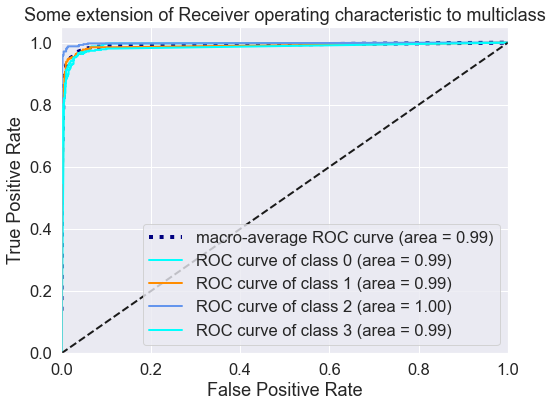

In [155]:
show_roc_auc(y_test_lbl, y_prob_knn)

**Полученные результаты с помощью метода ближайших соседей оказались несколько хуже, чем при Логистической регрессии, но в целом результат тоже хороший. Возможно, регуляризация сыграла значимую роль в предыдущем методе, т.к. позволила найти более сложные зависимости**

## 3. Decision tree classifier
**В качестве следующего классификатора были выбраны деревья решений**

In [73]:
from sklearn.tree import DecisionTreeClassifier

In [162]:
decision_param = {
    "criterion" : ["gini", "entropy"],
    "max_depth" : range(4, 40, 2),
    "min_samples_split" : range(2, 20, 2)    
}
grid_tree = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=decision_param,
                   cv=5, verbose=3, scoring='f1_macro')
grid_tree.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] criterion=gini, max_depth=4, min_samples_split=2 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=4, min_samples_split=2, score=0.653, total=   0.3s
[CV] criterion=gini, max_depth=4, min_samples_split=2 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  criterion=gini, max_depth=4, min_samples_split=2, score=0.608, total=   0.3s
[CV] criterion=gini, max_depth=4, min_samples_split=2 ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV]  criterion=gini, max_depth=4, min_samples_split=2, score=0.625, total=   0.3s
[CV] criterion=gini, max_depth=4, min_samples_split=2 ................
[CV]  criterion=gini, max_depth=4, min_samples_split=2, score=0.626, total=   0.3s
[CV] criterion=gini, max_depth=4, min_samples_split=2 ................
[CV]  criterion=gini, max_depth=4, min_samples_split=2, score=0.617, total=   0.3s
[CV] criterion=gini, max_depth=4, min_samples_split=4 ................
[CV]  criterion=gini, max_depth=4, min_samples_split=4, score=0.655, total=   0.3s
[CV] criterion=gini, max_depth=4, min_samples_split=4 ................
[CV]  criterion=gini, max_depth=4, min_samples_split=4, score=0.608, total=   0.3s
[CV] criterion=gini, max_depth=4, min_samples_split=4 ................
[CV]  criterion=gini, max_depth=4, min_samples_split=4, score=0.625, total=   0.3s
[CV] criterion=gini, max_depth=4, min_samples_split=4 ................
[CV]  criterion=gini, max_depth=4, min_samples_split=4, score=0.625, total= 

[CV]  criterion=gini, max_depth=6, min_samples_split=6, score=0.663, total=   0.3s
[CV] criterion=gini, max_depth=6, min_samples_split=6 ................
[CV]  criterion=gini, max_depth=6, min_samples_split=6, score=0.711, total=   0.2s
[CV] criterion=gini, max_depth=6, min_samples_split=6 ................
[CV]  criterion=gini, max_depth=6, min_samples_split=6, score=0.686, total=   0.2s
[CV] criterion=gini, max_depth=6, min_samples_split=6 ................
[CV]  criterion=gini, max_depth=6, min_samples_split=6, score=0.673, total=   0.2s
[CV] criterion=gini, max_depth=6, min_samples_split=8 ................
[CV]  criterion=gini, max_depth=6, min_samples_split=8, score=0.713, total=   0.2s
[CV] criterion=gini, max_depth=6, min_samples_split=8 ................
[CV]  criterion=gini, max_depth=6, min_samples_split=8, score=0.670, total=   0.2s
[CV] criterion=gini, max_depth=6, min_samples_split=8 ................
[CV]  criterion=gini, max_depth=6, min_samples_split=8, score=0.709, total= 

[CV]  criterion=gini, max_depth=8, min_samples_split=10, score=0.759, total=   0.3s
[CV] criterion=gini, max_depth=8, min_samples_split=10 ...............
[CV]  criterion=gini, max_depth=8, min_samples_split=10, score=0.735, total=   0.3s
[CV] criterion=gini, max_depth=8, min_samples_split=10 ...............
[CV]  criterion=gini, max_depth=8, min_samples_split=10, score=0.770, total=   0.3s
[CV] criterion=gini, max_depth=8, min_samples_split=10 ...............
[CV]  criterion=gini, max_depth=8, min_samples_split=10, score=0.737, total=   0.3s
[CV] criterion=gini, max_depth=8, min_samples_split=10 ...............
[CV]  criterion=gini, max_depth=8, min_samples_split=10, score=0.746, total=   0.3s
[CV] criterion=gini, max_depth=8, min_samples_split=12 ...............
[CV]  criterion=gini, max_depth=8, min_samples_split=12, score=0.764, total=   0.3s
[CV] criterion=gini, max_depth=8, min_samples_split=12 ...............
[CV]  criterion=gini, max_depth=8, min_samples_split=12, score=0.737, 

[CV]  criterion=gini, max_depth=10, min_samples_split=12, score=0.774, total=   0.4s
[CV] criterion=gini, max_depth=10, min_samples_split=12 ..............
[CV]  criterion=gini, max_depth=10, min_samples_split=12, score=0.783, total=   0.3s
[CV] criterion=gini, max_depth=10, min_samples_split=14 ..............
[CV]  criterion=gini, max_depth=10, min_samples_split=14, score=0.797, total=   0.3s
[CV] criterion=gini, max_depth=10, min_samples_split=14 ..............
[CV]  criterion=gini, max_depth=10, min_samples_split=14, score=0.782, total=   0.3s
[CV] criterion=gini, max_depth=10, min_samples_split=14 ..............
[CV]  criterion=gini, max_depth=10, min_samples_split=14, score=0.805, total=   0.3s
[CV] criterion=gini, max_depth=10, min_samples_split=14 ..............
[CV]  criterion=gini, max_depth=10, min_samples_split=14, score=0.775, total=   0.3s
[CV] criterion=gini, max_depth=10, min_samples_split=14 ..............
[CV]  criterion=gini, max_depth=10, min_samples_split=14, score=

[CV]  criterion=gini, max_depth=12, min_samples_split=16, score=0.810, total=   0.4s
[CV] criterion=gini, max_depth=12, min_samples_split=16 ..............
[CV]  criterion=gini, max_depth=12, min_samples_split=16, score=0.827, total=   0.4s
[CV] criterion=gini, max_depth=12, min_samples_split=16 ..............
[CV]  criterion=gini, max_depth=12, min_samples_split=16, score=0.794, total=   0.4s
[CV] criterion=gini, max_depth=12, min_samples_split=16 ..............
[CV]  criterion=gini, max_depth=12, min_samples_split=16, score=0.802, total=   0.4s
[CV] criterion=gini, max_depth=12, min_samples_split=18 ..............
[CV]  criterion=gini, max_depth=12, min_samples_split=18, score=0.821, total=   0.4s
[CV] criterion=gini, max_depth=12, min_samples_split=18 ..............
[CV]  criterion=gini, max_depth=12, min_samples_split=18, score=0.811, total=   0.4s
[CV] criterion=gini, max_depth=12, min_samples_split=18 ..............
[CV]  criterion=gini, max_depth=12, min_samples_split=18, score=

[CV]  criterion=gini, max_depth=14, min_samples_split=18, score=0.824, total=   0.4s
[CV] criterion=gini, max_depth=16, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=16, min_samples_split=2, score=0.845, total=   0.4s
[CV] criterion=gini, max_depth=16, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=16, min_samples_split=2, score=0.835, total=   0.5s
[CV] criterion=gini, max_depth=16, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=16, min_samples_split=2, score=0.839, total=   0.5s
[CV] criterion=gini, max_depth=16, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=16, min_samples_split=2, score=0.825, total=   0.5s
[CV] criterion=gini, max_depth=16, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=16, min_samples_split=2, score=0.839, total=   0.5s
[CV] criterion=gini, max_depth=16, min_samples_split=4 ...............
[CV]  criterion=gini, max_depth=16, min_samples_split=4, score=0.846,

[CV]  criterion=gini, max_depth=18, min_samples_split=4, score=0.855, total=   0.5s
[CV] criterion=gini, max_depth=18, min_samples_split=4 ...............
[CV]  criterion=gini, max_depth=18, min_samples_split=4, score=0.834, total=   0.5s
[CV] criterion=gini, max_depth=18, min_samples_split=4 ...............
[CV]  criterion=gini, max_depth=18, min_samples_split=4, score=0.841, total=   0.5s
[CV] criterion=gini, max_depth=18, min_samples_split=6 ...............
[CV]  criterion=gini, max_depth=18, min_samples_split=6, score=0.858, total=   0.5s
[CV] criterion=gini, max_depth=18, min_samples_split=6 ...............
[CV]  criterion=gini, max_depth=18, min_samples_split=6, score=0.844, total=   0.5s
[CV] criterion=gini, max_depth=18, min_samples_split=6 ...............
[CV]  criterion=gini, max_depth=18, min_samples_split=6, score=0.856, total=   0.5s
[CV] criterion=gini, max_depth=18, min_samples_split=6 ...............
[CV]  criterion=gini, max_depth=18, min_samples_split=6, score=0.832, 

[CV]  criterion=gini, max_depth=20, min_samples_split=8, score=0.862, total=   0.5s
[CV] criterion=gini, max_depth=20, min_samples_split=8 ...............
[CV]  criterion=gini, max_depth=20, min_samples_split=8, score=0.853, total=   0.5s
[CV] criterion=gini, max_depth=20, min_samples_split=8 ...............
[CV]  criterion=gini, max_depth=20, min_samples_split=8, score=0.849, total=   0.5s
[CV] criterion=gini, max_depth=20, min_samples_split=8 ...............
[CV]  criterion=gini, max_depth=20, min_samples_split=8, score=0.813, total=   0.5s
[CV] criterion=gini, max_depth=20, min_samples_split=8 ...............
[CV]  criterion=gini, max_depth=20, min_samples_split=8, score=0.834, total=   0.5s
[CV] criterion=gini, max_depth=20, min_samples_split=10 ..............
[CV]  criterion=gini, max_depth=20, min_samples_split=10, score=0.855, total=   0.5s
[CV] criterion=gini, max_depth=20, min_samples_split=10 ..............
[CV]  criterion=gini, max_depth=20, min_samples_split=10, score=0.844

[CV]  criterion=gini, max_depth=22, min_samples_split=10, score=0.824, total=   0.5s
[CV] criterion=gini, max_depth=22, min_samples_split=10 ..............
[CV]  criterion=gini, max_depth=22, min_samples_split=10, score=0.836, total=   0.6s
[CV] criterion=gini, max_depth=22, min_samples_split=12 ..............
[CV]  criterion=gini, max_depth=22, min_samples_split=12, score=0.868, total=   0.5s
[CV] criterion=gini, max_depth=22, min_samples_split=12 ..............
[CV]  criterion=gini, max_depth=22, min_samples_split=12, score=0.844, total=   0.5s
[CV] criterion=gini, max_depth=22, min_samples_split=12 ..............
[CV]  criterion=gini, max_depth=22, min_samples_split=12, score=0.841, total=   0.5s
[CV] criterion=gini, max_depth=22, min_samples_split=12 ..............
[CV]  criterion=gini, max_depth=22, min_samples_split=12, score=0.823, total=   0.5s
[CV] criterion=gini, max_depth=22, min_samples_split=12 ..............
[CV]  criterion=gini, max_depth=22, min_samples_split=12, score=

[CV]  criterion=gini, max_depth=24, min_samples_split=14, score=0.850, total=   0.6s
[CV] criterion=gini, max_depth=24, min_samples_split=14 ..............
[CV]  criterion=gini, max_depth=24, min_samples_split=14, score=0.843, total=   0.6s
[CV] criterion=gini, max_depth=24, min_samples_split=14 ..............
[CV]  criterion=gini, max_depth=24, min_samples_split=14, score=0.821, total=   0.5s
[CV] criterion=gini, max_depth=24, min_samples_split=14 ..............
[CV]  criterion=gini, max_depth=24, min_samples_split=14, score=0.837, total=   0.6s
[CV] criterion=gini, max_depth=24, min_samples_split=16 ..............
[CV]  criterion=gini, max_depth=24, min_samples_split=16, score=0.857, total=   0.6s
[CV] criterion=gini, max_depth=24, min_samples_split=16 ..............
[CV]  criterion=gini, max_depth=24, min_samples_split=16, score=0.855, total=   0.6s
[CV] criterion=gini, max_depth=24, min_samples_split=16 ..............
[CV]  criterion=gini, max_depth=24, min_samples_split=16, score=

[CV]  criterion=gini, max_depth=26, min_samples_split=16, score=0.842, total=   0.6s
[CV] criterion=gini, max_depth=26, min_samples_split=18 ..............
[CV]  criterion=gini, max_depth=26, min_samples_split=18, score=0.846, total=   0.6s
[CV] criterion=gini, max_depth=26, min_samples_split=18 ..............
[CV]  criterion=gini, max_depth=26, min_samples_split=18, score=0.855, total=   0.6s
[CV] criterion=gini, max_depth=26, min_samples_split=18 ..............
[CV]  criterion=gini, max_depth=26, min_samples_split=18, score=0.844, total=   0.5s
[CV] criterion=gini, max_depth=26, min_samples_split=18 ..............
[CV]  criterion=gini, max_depth=26, min_samples_split=18, score=0.826, total=   0.6s
[CV] criterion=gini, max_depth=26, min_samples_split=18 ..............
[CV]  criterion=gini, max_depth=26, min_samples_split=18, score=0.843, total=   0.5s
[CV] criterion=gini, max_depth=28, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=28, min_samples_split=2, score=0

[CV]  criterion=gini, max_depth=30, min_samples_split=2, score=0.853, total=   0.6s
[CV] criterion=gini, max_depth=30, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=30, min_samples_split=2, score=0.821, total=   0.6s
[CV] criterion=gini, max_depth=30, min_samples_split=2 ...............
[CV]  criterion=gini, max_depth=30, min_samples_split=2, score=0.845, total=   0.7s
[CV] criterion=gini, max_depth=30, min_samples_split=4 ...............
[CV]  criterion=gini, max_depth=30, min_samples_split=4, score=0.863, total=   0.6s
[CV] criterion=gini, max_depth=30, min_samples_split=4 ...............
[CV]  criterion=gini, max_depth=30, min_samples_split=4, score=0.848, total=   0.6s
[CV] criterion=gini, max_depth=30, min_samples_split=4 ...............
[CV]  criterion=gini, max_depth=30, min_samples_split=4, score=0.841, total=   0.6s
[CV] criterion=gini, max_depth=30, min_samples_split=4 ...............
[CV]  criterion=gini, max_depth=30, min_samples_split=4, score=0.814, 

[CV]  criterion=gini, max_depth=32, min_samples_split=6, score=0.865, total=   0.6s
[CV] criterion=gini, max_depth=32, min_samples_split=6 ...............
[CV]  criterion=gini, max_depth=32, min_samples_split=6, score=0.838, total=   0.6s
[CV] criterion=gini, max_depth=32, min_samples_split=6 ...............
[CV]  criterion=gini, max_depth=32, min_samples_split=6, score=0.840, total=   0.6s
[CV] criterion=gini, max_depth=32, min_samples_split=6 ...............
[CV]  criterion=gini, max_depth=32, min_samples_split=6, score=0.831, total=   0.6s
[CV] criterion=gini, max_depth=32, min_samples_split=6 ...............
[CV]  criterion=gini, max_depth=32, min_samples_split=6, score=0.851, total=   0.6s
[CV] criterion=gini, max_depth=32, min_samples_split=8 ...............
[CV]  criterion=gini, max_depth=32, min_samples_split=8, score=0.860, total=   0.6s
[CV] criterion=gini, max_depth=32, min_samples_split=8 ...............
[CV]  criterion=gini, max_depth=32, min_samples_split=8, score=0.845, 

[CV]  criterion=gini, max_depth=34, min_samples_split=8, score=0.828, total=   0.7s
[CV] criterion=gini, max_depth=34, min_samples_split=8 ...............
[CV]  criterion=gini, max_depth=34, min_samples_split=8, score=0.843, total=   0.7s
[CV] criterion=gini, max_depth=34, min_samples_split=10 ..............
[CV]  criterion=gini, max_depth=34, min_samples_split=10, score=0.855, total=   0.6s
[CV] criterion=gini, max_depth=34, min_samples_split=10 ..............
[CV]  criterion=gini, max_depth=34, min_samples_split=10, score=0.845, total=   0.6s
[CV] criterion=gini, max_depth=34, min_samples_split=10 ..............
[CV]  criterion=gini, max_depth=34, min_samples_split=10, score=0.851, total=   0.6s
[CV] criterion=gini, max_depth=34, min_samples_split=10 ..............
[CV]  criterion=gini, max_depth=34, min_samples_split=10, score=0.825, total=   0.6s
[CV] criterion=gini, max_depth=34, min_samples_split=10 ..............
[CV]  criterion=gini, max_depth=34, min_samples_split=10, score=0.

[CV]  criterion=gini, max_depth=36, min_samples_split=12, score=0.852, total=   0.6s
[CV] criterion=gini, max_depth=36, min_samples_split=12 ..............
[CV]  criterion=gini, max_depth=36, min_samples_split=12, score=0.849, total=   0.6s
[CV] criterion=gini, max_depth=36, min_samples_split=12 ..............
[CV]  criterion=gini, max_depth=36, min_samples_split=12, score=0.820, total=   0.6s
[CV] criterion=gini, max_depth=36, min_samples_split=12 ..............
[CV]  criterion=gini, max_depth=36, min_samples_split=12, score=0.846, total=   0.6s
[CV] criterion=gini, max_depth=36, min_samples_split=14 ..............
[CV]  criterion=gini, max_depth=36, min_samples_split=14, score=0.868, total=   0.6s
[CV] criterion=gini, max_depth=36, min_samples_split=14 ..............
[CV]  criterion=gini, max_depth=36, min_samples_split=14, score=0.846, total=   0.6s
[CV] criterion=gini, max_depth=36, min_samples_split=14 ..............
[CV]  criterion=gini, max_depth=36, min_samples_split=14, score=

[CV]  criterion=gini, max_depth=38, min_samples_split=14, score=0.851, total=   0.6s
[CV] criterion=gini, max_depth=38, min_samples_split=16 ..............
[CV]  criterion=gini, max_depth=38, min_samples_split=16, score=0.855, total=   0.6s
[CV] criterion=gini, max_depth=38, min_samples_split=16 ..............
[CV]  criterion=gini, max_depth=38, min_samples_split=16, score=0.825, total=   0.6s
[CV] criterion=gini, max_depth=38, min_samples_split=16 ..............
[CV]  criterion=gini, max_depth=38, min_samples_split=16, score=0.851, total=   0.6s
[CV] criterion=gini, max_depth=38, min_samples_split=16 ..............
[CV]  criterion=gini, max_depth=38, min_samples_split=16, score=0.826, total=   0.7s
[CV] criterion=gini, max_depth=38, min_samples_split=16 ..............
[CV]  criterion=gini, max_depth=38, min_samples_split=16, score=0.856, total=   0.6s
[CV] criterion=gini, max_depth=38, min_samples_split=18 ..............
[CV]  criterion=gini, max_depth=38, min_samples_split=18, score=

[CV]  criterion=entropy, max_depth=4, min_samples_split=18, score=0.622, total=   0.3s
[CV] criterion=entropy, max_depth=4, min_samples_split=18 ............
[CV]  criterion=entropy, max_depth=4, min_samples_split=18, score=0.619, total=   0.3s
[CV] criterion=entropy, max_depth=4, min_samples_split=18 ............
[CV]  criterion=entropy, max_depth=4, min_samples_split=18, score=0.610, total=   0.3s
[CV] criterion=entropy, max_depth=6, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=6, min_samples_split=2, score=0.683, total=   0.4s
[CV] criterion=entropy, max_depth=6, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=6, min_samples_split=2, score=0.679, total=   0.3s
[CV] criterion=entropy, max_depth=6, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=6, min_samples_split=2, score=0.723, total=   0.4s
[CV] criterion=entropy, max_depth=6, min_samples_split=2 .............
[CV]  criterion=entropy, max_depth=6, min_samples_split

[CV]  criterion=entropy, max_depth=8, min_samples_split=4, score=0.715, total=   0.5s
[CV] criterion=entropy, max_depth=8, min_samples_split=4 .............
[CV]  criterion=entropy, max_depth=8, min_samples_split=4, score=0.705, total=   0.5s
[CV] criterion=entropy, max_depth=8, min_samples_split=4 .............
[CV]  criterion=entropy, max_depth=8, min_samples_split=4, score=0.781, total=   0.5s
[CV] criterion=entropy, max_depth=8, min_samples_split=4 .............
[CV]  criterion=entropy, max_depth=8, min_samples_split=4, score=0.721, total=   0.4s
[CV] criterion=entropy, max_depth=8, min_samples_split=4 .............
[CV]  criterion=entropy, max_depth=8, min_samples_split=4, score=0.702, total=   0.5s
[CV] criterion=entropy, max_depth=8, min_samples_split=6 .............
[CV]  criterion=entropy, max_depth=8, min_samples_split=6, score=0.714, total=   0.4s
[CV] criterion=entropy, max_depth=8, min_samples_split=6 .............
[CV]  criterion=entropy, max_depth=8, min_samples_split=6,

[CV]  criterion=entropy, max_depth=10, min_samples_split=6, score=0.806, total=   0.7s
[CV] criterion=entropy, max_depth=10, min_samples_split=6 ............
[CV]  criterion=entropy, max_depth=10, min_samples_split=6, score=0.766, total=   0.6s
[CV] criterion=entropy, max_depth=10, min_samples_split=6 ............
[CV]  criterion=entropy, max_depth=10, min_samples_split=6, score=0.741, total=   0.6s
[CV] criterion=entropy, max_depth=10, min_samples_split=8 ............
[CV]  criterion=entropy, max_depth=10, min_samples_split=8, score=0.757, total=   0.5s
[CV] criterion=entropy, max_depth=10, min_samples_split=8 ............
[CV]  criterion=entropy, max_depth=10, min_samples_split=8, score=0.755, total=   0.5s
[CV] criterion=entropy, max_depth=10, min_samples_split=8 ............
[CV]  criterion=entropy, max_depth=10, min_samples_split=8, score=0.803, total=   0.5s
[CV] criterion=entropy, max_depth=10, min_samples_split=8 ............
[CV]  criterion=entropy, max_depth=10, min_samples_s

[CV]  criterion=entropy, max_depth=12, min_samples_split=8, score=0.771, total=   0.6s
[CV] criterion=entropy, max_depth=12, min_samples_split=10 ...........
[CV]  criterion=entropy, max_depth=12, min_samples_split=10, score=0.783, total=   0.6s
[CV] criterion=entropy, max_depth=12, min_samples_split=10 ...........
[CV]  criterion=entropy, max_depth=12, min_samples_split=10, score=0.811, total=   0.5s
[CV] criterion=entropy, max_depth=12, min_samples_split=10 ...........
[CV]  criterion=entropy, max_depth=12, min_samples_split=10, score=0.820, total=   0.6s
[CV] criterion=entropy, max_depth=12, min_samples_split=10 ...........
[CV]  criterion=entropy, max_depth=12, min_samples_split=10, score=0.779, total=   0.5s
[CV] criterion=entropy, max_depth=12, min_samples_split=10 ...........
[CV]  criterion=entropy, max_depth=12, min_samples_split=10, score=0.774, total=   0.5s
[CV] criterion=entropy, max_depth=12, min_samples_split=12 ...........
[CV]  criterion=entropy, max_depth=12, min_samp

[CV]  criterion=entropy, max_depth=14, min_samples_split=12, score=0.809, total=   0.6s
[CV] criterion=entropy, max_depth=14, min_samples_split=12 ...........
[CV]  criterion=entropy, max_depth=14, min_samples_split=12, score=0.807, total=   0.6s
[CV] criterion=entropy, max_depth=14, min_samples_split=12 ...........
[CV]  criterion=entropy, max_depth=14, min_samples_split=12, score=0.783, total=   0.6s
[CV] criterion=entropy, max_depth=14, min_samples_split=12 ...........
[CV]  criterion=entropy, max_depth=14, min_samples_split=12, score=0.797, total=   0.6s
[CV] criterion=entropy, max_depth=14, min_samples_split=14 ...........
[CV]  criterion=entropy, max_depth=14, min_samples_split=14, score=0.805, total=   0.6s
[CV] criterion=entropy, max_depth=14, min_samples_split=14 ...........
[CV]  criterion=entropy, max_depth=14, min_samples_split=14, score=0.819, total=   0.6s
[CV] criterion=entropy, max_depth=14, min_samples_split=14 ...........
[CV]  criterion=entropy, max_depth=14, min_sam

[CV]  criterion=entropy, max_depth=16, min_samples_split=14, score=0.800, total=   0.6s
[CV] criterion=entropy, max_depth=16, min_samples_split=14 ...........
[CV]  criterion=entropy, max_depth=16, min_samples_split=14, score=0.808, total=   0.7s
[CV] criterion=entropy, max_depth=16, min_samples_split=16 ...........
[CV]  criterion=entropy, max_depth=16, min_samples_split=16, score=0.827, total=   0.7s
[CV] criterion=entropy, max_depth=16, min_samples_split=16 ...........
[CV]  criterion=entropy, max_depth=16, min_samples_split=16, score=0.835, total=   0.6s
[CV] criterion=entropy, max_depth=16, min_samples_split=16 ...........
[CV]  criterion=entropy, max_depth=16, min_samples_split=16, score=0.824, total=   0.7s
[CV] criterion=entropy, max_depth=16, min_samples_split=16 ...........
[CV]  criterion=entropy, max_depth=16, min_samples_split=16, score=0.803, total=   0.6s
[CV] criterion=entropy, max_depth=16, min_samples_split=16 ...........
[CV]  criterion=entropy, max_depth=16, min_sam

[CV]  criterion=entropy, max_depth=18, min_samples_split=18, score=0.827, total=   0.7s
[CV] criterion=entropy, max_depth=18, min_samples_split=18 ...........
[CV]  criterion=entropy, max_depth=18, min_samples_split=18, score=0.845, total=   0.7s
[CV] criterion=entropy, max_depth=18, min_samples_split=18 ...........
[CV]  criterion=entropy, max_depth=18, min_samples_split=18, score=0.843, total=   0.7s
[CV] criterion=entropy, max_depth=18, min_samples_split=18 ...........
[CV]  criterion=entropy, max_depth=18, min_samples_split=18, score=0.821, total=   0.6s
[CV] criterion=entropy, max_depth=18, min_samples_split=18 ...........
[CV]  criterion=entropy, max_depth=18, min_samples_split=18, score=0.808, total=   0.7s
[CV] criterion=entropy, max_depth=20, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=20, min_samples_split=2, score=0.827, total=   0.7s
[CV] criterion=entropy, max_depth=20, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=20, min_samp

[CV]  criterion=entropy, max_depth=22, min_samples_split=2, score=0.833, total=   0.8s
[CV] criterion=entropy, max_depth=22, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=22, min_samples_split=2, score=0.821, total=   0.7s
[CV] criterion=entropy, max_depth=22, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=22, min_samples_split=2, score=0.813, total=   0.8s
[CV] criterion=entropy, max_depth=22, min_samples_split=4 ............
[CV]  criterion=entropy, max_depth=22, min_samples_split=4, score=0.838, total=   0.7s
[CV] criterion=entropy, max_depth=22, min_samples_split=4 ............
[CV]  criterion=entropy, max_depth=22, min_samples_split=4, score=0.845, total=   0.7s
[CV] criterion=entropy, max_depth=22, min_samples_split=4 ............
[CV]  criterion=entropy, max_depth=22, min_samples_split=4, score=0.844, total=   0.8s
[CV] criterion=entropy, max_depth=22, min_samples_split=4 ............
[CV]  criterion=entropy, max_depth=22, min_samples_s

[CV]  criterion=entropy, max_depth=24, min_samples_split=4, score=0.822, total=   0.8s
[CV] criterion=entropy, max_depth=24, min_samples_split=6 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=6, score=0.833, total=   0.7s
[CV] criterion=entropy, max_depth=24, min_samples_split=6 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=6, score=0.849, total=   0.7s
[CV] criterion=entropy, max_depth=24, min_samples_split=6 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=6, score=0.846, total=   0.8s
[CV] criterion=entropy, max_depth=24, min_samples_split=6 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=6, score=0.810, total=   0.7s
[CV] criterion=entropy, max_depth=24, min_samples_split=6 ............
[CV]  criterion=entropy, max_depth=24, min_samples_split=6, score=0.815, total=   0.7s
[CV] criterion=entropy, max_depth=24, min_samples_split=8 ............
[CV]  criterion=entropy, max_depth=24, min_samples_s

[CV]  criterion=entropy, max_depth=26, min_samples_split=8, score=0.845, total=   0.7s
[CV] criterion=entropy, max_depth=26, min_samples_split=8 ............
[CV]  criterion=entropy, max_depth=26, min_samples_split=8, score=0.848, total=   0.8s
[CV] criterion=entropy, max_depth=26, min_samples_split=8 ............
[CV]  criterion=entropy, max_depth=26, min_samples_split=8, score=0.815, total=   0.7s
[CV] criterion=entropy, max_depth=26, min_samples_split=8 ............
[CV]  criterion=entropy, max_depth=26, min_samples_split=8, score=0.818, total=   0.7s
[CV] criterion=entropy, max_depth=26, min_samples_split=10 ...........
[CV]  criterion=entropy, max_depth=26, min_samples_split=10, score=0.835, total=   0.7s
[CV] criterion=entropy, max_depth=26, min_samples_split=10 ...........
[CV]  criterion=entropy, max_depth=26, min_samples_split=10, score=0.853, total=   0.7s
[CV] criterion=entropy, max_depth=26, min_samples_split=10 ...........
[CV]  criterion=entropy, max_depth=26, min_samples

[CV]  criterion=entropy, max_depth=28, min_samples_split=10, score=0.815, total=   0.8s
[CV] criterion=entropy, max_depth=28, min_samples_split=10 ...........
[CV]  criterion=entropy, max_depth=28, min_samples_split=10, score=0.825, total=   0.7s
[CV] criterion=entropy, max_depth=28, min_samples_split=12 ...........
[CV]  criterion=entropy, max_depth=28, min_samples_split=12, score=0.833, total=   0.8s
[CV] criterion=entropy, max_depth=28, min_samples_split=12 ...........
[CV]  criterion=entropy, max_depth=28, min_samples_split=12, score=0.847, total=   0.7s
[CV] criterion=entropy, max_depth=28, min_samples_split=12 ...........
[CV]  criterion=entropy, max_depth=28, min_samples_split=12, score=0.844, total=   0.8s
[CV] criterion=entropy, max_depth=28, min_samples_split=12 ...........
[CV]  criterion=entropy, max_depth=28, min_samples_split=12, score=0.803, total=   0.7s
[CV] criterion=entropy, max_depth=28, min_samples_split=12 ...........
[CV]  criterion=entropy, max_depth=28, min_sam

[CV]  criterion=entropy, max_depth=30, min_samples_split=14, score=0.838, total=   0.7s
[CV] criterion=entropy, max_depth=30, min_samples_split=14 ...........
[CV]  criterion=entropy, max_depth=30, min_samples_split=14, score=0.853, total=   0.7s
[CV] criterion=entropy, max_depth=30, min_samples_split=14 ...........
[CV]  criterion=entropy, max_depth=30, min_samples_split=14, score=0.849, total=   0.8s
[CV] criterion=entropy, max_depth=30, min_samples_split=14 ...........
[CV]  criterion=entropy, max_depth=30, min_samples_split=14, score=0.825, total=   0.7s
[CV] criterion=entropy, max_depth=30, min_samples_split=14 ...........
[CV]  criterion=entropy, max_depth=30, min_samples_split=14, score=0.813, total=   0.7s
[CV] criterion=entropy, max_depth=30, min_samples_split=16 ...........
[CV]  criterion=entropy, max_depth=30, min_samples_split=16, score=0.833, total=   0.7s
[CV] criterion=entropy, max_depth=30, min_samples_split=16 ...........
[CV]  criterion=entropy, max_depth=30, min_sam

[CV]  criterion=entropy, max_depth=32, min_samples_split=16, score=0.844, total=   0.8s
[CV] criterion=entropy, max_depth=32, min_samples_split=16 ...........
[CV]  criterion=entropy, max_depth=32, min_samples_split=16, score=0.824, total=   0.7s
[CV] criterion=entropy, max_depth=32, min_samples_split=16 ...........
[CV]  criterion=entropy, max_depth=32, min_samples_split=16, score=0.821, total=   0.7s
[CV] criterion=entropy, max_depth=32, min_samples_split=18 ...........
[CV]  criterion=entropy, max_depth=32, min_samples_split=18, score=0.833, total=   0.8s
[CV] criterion=entropy, max_depth=32, min_samples_split=18 ...........
[CV]  criterion=entropy, max_depth=32, min_samples_split=18, score=0.846, total=   0.7s
[CV] criterion=entropy, max_depth=32, min_samples_split=18 ...........
[CV]  criterion=entropy, max_depth=32, min_samples_split=18, score=0.847, total=   0.8s
[CV] criterion=entropy, max_depth=32, min_samples_split=18 ...........
[CV]  criterion=entropy, max_depth=32, min_sam

[CV]  criterion=entropy, max_depth=34, min_samples_split=18, score=0.810, total=   0.7s
[CV] criterion=entropy, max_depth=36, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=36, min_samples_split=2, score=0.835, total=   0.8s
[CV] criterion=entropy, max_depth=36, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=36, min_samples_split=2, score=0.843, total=   0.8s
[CV] criterion=entropy, max_depth=36, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=36, min_samples_split=2, score=0.839, total=   0.9s
[CV] criterion=entropy, max_depth=36, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=36, min_samples_split=2, score=0.810, total=   0.8s
[CV] criterion=entropy, max_depth=36, min_samples_split=2 ............
[CV]  criterion=entropy, max_depth=36, min_samples_split=2, score=0.816, total=   0.8s
[CV] criterion=entropy, max_depth=36, min_samples_split=4 ............
[CV]  criterion=entropy, max_depth=36, min_samples_

[CV]  criterion=entropy, max_depth=38, min_samples_split=4, score=0.853, total=   0.8s
[CV] criterion=entropy, max_depth=38, min_samples_split=4 ............
[CV]  criterion=entropy, max_depth=38, min_samples_split=4, score=0.852, total=   0.9s
[CV] criterion=entropy, max_depth=38, min_samples_split=4 ............
[CV]  criterion=entropy, max_depth=38, min_samples_split=4, score=0.807, total=   0.7s
[CV] criterion=entropy, max_depth=38, min_samples_split=4 ............
[CV]  criterion=entropy, max_depth=38, min_samples_split=4, score=0.818, total=   0.8s
[CV] criterion=entropy, max_depth=38, min_samples_split=6 ............
[CV]  criterion=entropy, max_depth=38, min_samples_split=6, score=0.841, total=   0.8s
[CV] criterion=entropy, max_depth=38, min_samples_split=6 ............
[CV]  criterion=entropy, max_depth=38, min_samples_split=6, score=0.855, total=   0.8s
[CV] criterion=entropy, max_depth=38, min_samples_split=6 ............
[CV]  criterion=entropy, max_depth=38, min_samples_s

[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed: 15.3min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(4, 40, 2),
                         'min_samples_split': range(2, 20, 2)},
             scoring='f1_macro', verbose=3)

In [164]:
grid_tree.best_params_

{'criterion': 'gini', 'max_depth': 32, 'min_samples_split': 2}

In [74]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=32, min_samples_split=2)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
y_prob_tree = tree.predict_proba(X_test)

In [ ]:
estimator = tree

n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)] 

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()

node_indicator = estimator.decision_path(X_test)

# Similarly, we can also have the leaves ids reached by each sample.

leave_id = estimator.apply(X_test)

# Now, it's possible to get the tests that were used to predict a sample or
# a group of samples. First, let's make it for the sample.

sample_id = 0
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print('Rules used to predict sample %s: ' % sample_id)
for node_id in node_index:
    if leave_id[sample_id] == node_id:
        continue

    if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision id node %s : (X_test[%s, %s] (= %s) %s %s)"
          % (node_id,
             sample_id,
             feature[node_id],
             X_test[sample_id, feature[node_id]],
             threshold_sign,
             threshold[node_id]))

# For a group of samples, we have the following common node.
sample_ids = [0, 1]
common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) ==
                len(sample_ids))

common_node_id = np.arange(n_nodes)[common_nodes]

print("\nThe following samples %s share the node %s in the tree"
      % (sample_ids, common_node_id))
print("It is %s %% of all nodes." % (100 * len(common_node_id) / n_nodes,))

**Выше функция для представления построенного дерева решений, по которому можно было бы определить, на какой глубине какие признаки сравнивались, т.е. какие были наиболее важными при принятии решений. Но т.к. глубина дерева 32, то не очень информативно смотрятся выходные данные (удалил, чтобы не загромождать). По первым пяти вершинам можно выделить какие-то компоненты:**<br>
node=0 test node: go to node 1 if X[:, 29962] <= 0.03140479139983654 else to node 314.<br>
	node=1 test node: go to node 2 if X[:, 12830] <= 0.02911064587533474 else to node 293.<br>
		node=2 test node: go to node 3 if X[:, 15080] <= 0.0067752511240541935 else to node 288.<br>
			node=3 test node: go to node 4 if X[:, 16061] <= 0.03249526582658291 else to node 273.<br>
				node=4 test node: go to node 5 if X[:, 22119] <= 0.02073610946536064 else to node 254.<br>
					node=5 test node: go to node 6 if X[:, 22539] <= 0.032256199046969414<br>
Можно посмотреть, что это за слова:

In [192]:
voc = vectorizer.vocabulary_
indexes = [29962, 12830, 15080, 16061, 22119, 22539]
for i in indexes:
    print(list(voc.keys())[list(voc.values()).index(i)])

украина
команда
матч
мужчина
пострадать
президент


**Большое преимущество деревьев в том, что структуру полученной модели легче интерпретировать. Можно предположить, что на первых этапах обученное дерево решений пыталется классифицировать спорт и политику, судя по полученным словам. Теперь посмотрим полученные метрики**

In [75]:
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print("Recall:", recall_score(y_test, y_pred_tree, average='macro'))
print("Precision:", precision_score(y_test, y_pred_tree, average='macro'))
print("F1:", f1_score(y_test, y_pred_tree, average='macro'))
print("ROC AUC:", roc_auc_score(y_test, y_prob_tree, average='macro', multi_class='ovr'))

Accuracy: 0.8367346938775511
Recall: 0.8368917952441393
Precision: 0.8371623564485102
F1: 0.8366701363382477
ROC AUC: 0.8955779623899096


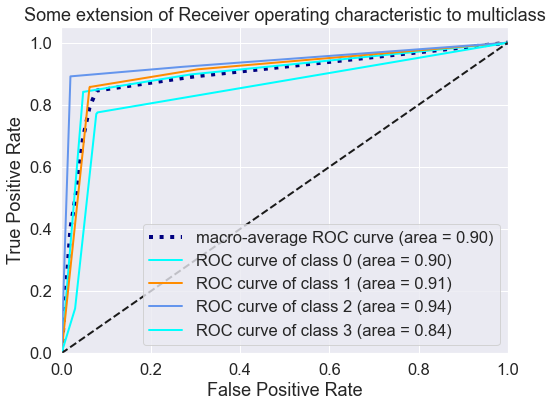

In [169]:
show_roc_auc(y_test_lbl, y_prob_tree)

**Точность модели оказалась значительно ниже, чем в предыдущих моделях. Возможно, ээто объясняется очень большим количеством фич относительно глебины дерева. Построить более качественную модель может оказаться неоправданно затратно по объему памяти**

## 4. Light Gradient Boosting
Т.к. одно дерево решений плохо справилось с задачей классификации текста в сравнениии с другими методами, то воспользуемся LightGBM. Принцип работы основан на использовании градиентного бустинга, т.е. объедениня разлчиных алгоритмов в один. По сравнению с традиционным алгоритмом бустинга, он имеет несколько отличий или улучшений, таких как регуляризация из трех частей(l1, l2 и кол-во листьев деревьев), рандомизация признаков используемых алгоритмов и учитывание не всех данных, а только объектов с большим градиентом (таковые имеют большую важность для направления обучения)

In [58]:
import lightgbm as lbm

In [78]:
%%time
decision_param = {
    "boosting_type" : ['gbdt', 'goss', 'rf'],
    "num_leaves" : [31, 64], 
    "n_estimators" : [50, 100, 150],
    "objective" : ["multiclass"],   
}
grid_gb = GridSearchCV(estimator=lbm.LGBMClassifier(), param_grid=decision_param,
                   cv=5, verbose=3, scoring='f1_macro')
grid_gb.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] boosting_type=gbdt, n_estimators=50, num_leaves=31, objective=multiclass 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  boosting_type=gbdt, n_estimators=50, num_leaves=31, objective=multiclass, score=0.947, total=   3.5s
[CV] boosting_type=gbdt, n_estimators=50, num_leaves=31, objective=multiclass 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV]  boosting_type=gbdt, n_estimators=50, num_leaves=31, objective=multiclass, score=0.938, total=   2.8s
[CV] boosting_type=gbdt, n_estimators=50, num_leaves=31, objective=multiclass 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s


[CV]  boosting_type=gbdt, n_estimators=50, num_leaves=31, objective=multiclass, score=0.939, total=   2.6s
[CV] boosting_type=gbdt, n_estimators=50, num_leaves=31, objective=multiclass 
[CV]  boosting_type=gbdt, n_estimators=50, num_leaves=31, objective=multiclass, score=0.926, total=   2.2s
[CV] boosting_type=gbdt, n_estimators=50, num_leaves=31, objective=multiclass 
[CV]  boosting_type=gbdt, n_estimators=50, num_leaves=31, objective=multiclass, score=0.947, total=   2.3s
[CV] boosting_type=gbdt, n_estimators=50, num_leaves=64, objective=multiclass 
[CV]  boosting_type=gbdt, n_estimators=50, num_leaves=64, objective=multiclass, score=0.945, total=   3.8s
[CV] boosting_type=gbdt, n_estimators=50, num_leaves=64, objective=multiclass 
[CV]  boosting_type=gbdt, n_estimators=50, num_leaves=64, objective=multiclass, score=0.933, total=   3.9s
[CV] boosting_type=gbdt, n_estimators=50, num_leaves=64, objective=multiclass 
[CV]  boosting_type=gbdt, n_estimators=50, num_leaves=64, objective=mu

[CV]  boosting_type=goss, n_estimators=100, num_leaves=64, objective=multiclass, score=0.935, total=   6.1s
[CV] boosting_type=goss, n_estimators=100, num_leaves=64, objective=multiclass 
[CV]  boosting_type=goss, n_estimators=100, num_leaves=64, objective=multiclass, score=0.938, total=   6.1s
[CV] boosting_type=goss, n_estimators=100, num_leaves=64, objective=multiclass 
[CV]  boosting_type=goss, n_estimators=100, num_leaves=64, objective=multiclass, score=0.929, total=   6.0s
[CV] boosting_type=goss, n_estimators=100, num_leaves=64, objective=multiclass 
[CV]  boosting_type=goss, n_estimators=100, num_leaves=64, objective=multiclass, score=0.948, total=   6.8s
[CV] boosting_type=goss, n_estimators=150, num_leaves=31, objective=multiclass 
[CV]  boosting_type=goss, n_estimators=150, num_leaves=31, objective=multiclass, score=0.952, total=   7.4s
[CV] boosting_type=goss, n_estimators=150, num_leaves=31, objective=multiclass 
[CV]  boosting_type=goss, n_estimators=150, num_leaves=31, o

C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Andrey\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "C:\Users\Andrey\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "C:\Users\Andrey\anaconda3\lib\site-packages\lightgbm\engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "C:\Users\Andrey\anaconda3\lib\site-packages\lightgbm\basic.py", line 2610, in __init__
    _safe_call(_LIB.LGBM_B

[CV]  boosting_type=rf, n_estimators=50, num_leaves=31, objective=multiclass, score=nan, total=   0.3s
[CV] boosting_type=rf, n_estimators=50, num_leaves=31, objective=multiclass 
[CV]  boosting_type=rf, n_estimators=50, num_leaves=31, objective=multiclass, score=nan, total=   0.3s
[CV] boosting_type=rf, n_estimators=50, num_leaves=31, objective=multiclass 
[CV]  boosting_type=rf, n_estimators=50, num_leaves=31, objective=multiclass, score=nan, total=   0.3s
[CV] boosting_type=rf, n_estimators=50, num_leaves=31, objective=multiclass 
[CV]  boosting_type=rf, n_estimators=50, num_leaves=31, objective=multiclass, score=nan, total=   0.3s
[CV] boosting_type=rf, n_estimators=50, num_leaves=31, objective=multiclass 
[CV]  boosting_type=rf, n_estimators=50, num_leaves=31, objective=multiclass, score=nan, total=   0.4s
[CV] boosting_type=rf, n_estimators=50, num_leaves=64, objective=multiclass 
[CV]  boosting_type=rf, n_estimators=50, num_leaves=64, objective=multiclass, score=nan, total=   0.

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  5.7min finished


Wall time: 5min 51s


GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'boosting_type': ['gbdt', 'goss', 'rf'],
                         'n_estimators': [50, 100, 150], 'num_leaves': [31, 64],
                         'objective': ['multiclass']},
             scoring='f1_macro', verbose=3)

In [79]:
grid_gb.best_params_

{'boosting_type': 'gbdt',
 'n_estimators': 150,
 'num_leaves': 31,
 'objective': 'multiclass'}

In [80]:
gb = lbm.LGBMClassifier(boosting_type='gbdt', n_estimators=150, num_leaves=31, objective='multiclass')
gb.fit(X_train, y_train)
y_pred_gb = model.predict(X_test)
y_prob_gb = model.predict_proba(X_test)

In [81]:
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Recall:", recall_score(y_test, y_pred_gb, average='macro'))
print("Precision:", precision_score(y_test, y_pred_gb, average='macro'))
print("F1:", f1_score(y_test, y_pred_gb, average='macro'))
print("ROC AUC:", roc_auc_score(y_test, y_prob_gb, average='macro', multi_class='ovr'))

Accuracy: 0.9453781512605042
Recall: 0.9452605335747022
Precision: 0.9452748207318823
F1: 0.9452446981849602
ROC AUC: 0.9926871671432638


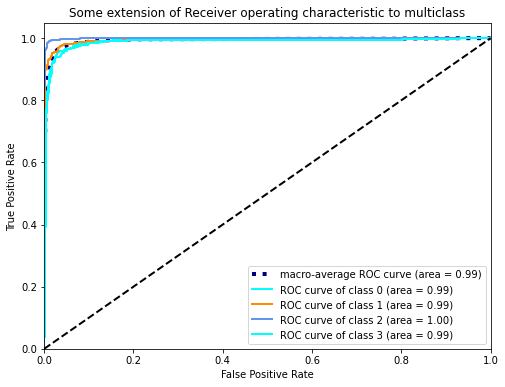

In [86]:
show_roc_auc(y_test_lbl, y_prob_gb)

**В градиентном бустинге деревья решений показали себя гораздо лучше, т.к. оказались оптимальным классификатором. Площадь под графиком кривой ROC-AUC тоже большая, как и в первых двух алгоритмах. Можно считать, что алгоритм обучен достаточно хорошо**

## 5. Support Vector Machine

In [90]:
from sklearn import svm

In [102]:
decision_param = {
    "C" : [0.01, 0.1, 1, 10, 100, 1000, 1e4],
    "penalty" : ["l2"], 
    "multi_class" : ["ovr"],
}
grid_svc = GridSearchCV(estimator=svm.LinearSVC(), param_grid=decision_param, 
                           cv=5, verbose=3, scoring='f1_macro')
grid_svc.fit(X_train, y_train)
y_pred_svc = grid_svc.predict(X_test)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] C=0.01, multi_class=ovr, penalty=l2 .............................
[CV] . C=0.01, multi_class=ovr, penalty=l2, score=0.955, total=   0.1s
[CV] C=0.01, multi_class=ovr, penalty=l2 .............................
[CV] . C=0.01, multi_class=ovr, penalty=l2, score=0.932, total=   0.1s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] C=0.01, multi_class=ovr, penalty=l2 .............................
[CV] . C=0.01, multi_class=ovr, penalty=l2, score=0.950, total=   0.1s
[CV] C=0.01, multi_class=ovr, penalty=l2 .............................
[CV] . C=0.01, multi_class=ovr, penalty=l2, score=0.937, total=   0.1s
[CV] C=0.01, multi_class=ovr, penalty=l2 .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] . C=0.01, multi_class=ovr, penalty=l2, score=0.932, total=   0.1s
[CV] C=0.1, multi_class=ovr, penalty=l2 ..............................
[CV] .. C=0.1, multi_class=ovr, penalty=l2, score=0.956, total=   0.1s
[CV] C=0.1, multi_class=ovr, penalty=l2 ..............................
[CV] .. C=0.1, multi_class=ovr, penalty=l2, score=0.950, total=   0.2s
[CV] C=0.1, multi_class=ovr, penalty=l2 ..............................
[CV] .. C=0.1, multi_class=ovr, penalty=l2, score=0.958, total=   0.1s
[CV] C=0.1, multi_class=ovr, penalty=l2 ..............................
[CV] .. C=0.1, multi_class=ovr, penalty=l2, score=0.945, total=   0.1s
[CV] C=0.1, multi_class=ovr, penalty=l2 ..............................
[CV] .. C=0.1, multi_class=ovr, penalty=l2, score=0.945, total=   0.1s
[CV] C=1, multi_class=ovr, penalty=l2 ................................
[CV] .... C=1, multi_class=ovr, penalty=l2, score=0.961, total=   0.1s
[CV] C=1, multi_class=ovr, penalty=l2 ................................
[CV] .

[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    6.5s finished


In [104]:
grid_svc.best_params_

{'C': 1, 'multi_class': 'ovr', 'penalty': 'l2'}

In [105]:
svc = svm.LinearSVC(C=1, multi_class='ovr', penalty='l2')
svc.fit(X_train, y_train)

LinearSVC(C=1)

In [106]:
y_pred_svc = svc.predict(X_test)

In [107]:
print("Accuracy:", accuracy_score(y_test, y_pred_svc))
print("Recall:", recall_score(y_test, y_pred_svc, average='macro'))
print("Precision:", precision_score(y_test, y_pred_svc, average='macro'))
print("F1:", f1_score(y_test, y_pred_svc, average='macro'))

Accuracy: 0.9627851140456183
Recall: 0.9626912113559676
Precision: 0.9626930447981101
F1: 0.9626872751778885


In [142]:
top_indexes = get_top_indexes(svc.coef_)

In [125]:
svc.classes_

array(['politika', 'proisshestviya', 'sport', 'tehnologii'], dtype=object)

**С помощью полученных весов можно увидеть, какие слова сыграли наибольшую роль для принятия того или иного класса:**

In [147]:
get_top_10_kewords(top_indexes, vectorizer.vocabulary_, svc.classes_)

Class name: politika
The most important words for this class:сша, война, посол, санкция, кремль, зеленский, мид, страна, президент, украина, 
Class name: proisshestviya
The most important words for this class:летний, shot, алмаата, произойти, погибнуть, полиция, здание, пострадать, женщина, мужчина, 
Class name: sport
The most important words for this class:олимпиада, футболист, тренер, сборная, чемпионат, чемпион, спортсмен, команда, матч, клуб, 
Class name: tehnologii
The most important words for this class:ракетный, земля, пользователь, космический, технология, исследование, специалист, проект, компания, учёный, 


**Изначально это не было сделано, чтобы было нагляднее здесь. Рассмотрим наиболее значимые слова из Логистической регрессии. Интересно будет наблюдать, сопадут ли они**

In [150]:
top_indexes_lr = get_top_indexes(log_reg.coef_)
get_top_10_kewords(top_indexes_lr, vectorizer.vocabulary_, log_reg.classes_)

Class name: politika
The most important words for this class:россия, санкция, война, мид, сша, конституция, байден, страна, президент, украина, 
Class name: proisshestviya
The most important words for this class:район, задержать, девушка, погибнуть, женщина, произойти, полиция, летний, мужчина, здание, 
Class name: sport
The most important words for this class:футболист, чемпион, олимпиада, чемпионат, турнир, сборная, спортсмен, клуб, матч, команда, 
Class name: tehnologii
The most important words for this class:минобороны, специалист, система, технология, соцсеть, проект, исследование, космический, компания, учёный, 


**Можно заметить, что в спортивных текстах многие слова совпали(9 из 10), в политике тоже (8 из 10). В текстах из раздела "Происшествия" и "Технологии" чуть поменьше: (6 и 7 из 10 слов соответственно). Это говорит о том, что данные слова (или сочетания из аднных наборов слов) могут быть определяющими в задаче классификации при встрече в тексте**

## 6. Naive Bayes classifier
Напоследок разбавим громоздкие и сложные модели наивным Байесовским классификатором

**Это один из двух классических наивных Байесовских алгоритмов, используемых для классификации текста. Здесь $$\hat{\theta}_{yi} = \frac{ N_{yi} + \alpha}{N_y + \alpha n}$$, где $$N_{yi} = \sum_{x \in T} x_i$$ и $$N_{yi} = \sum_{x \in T} x_i$$. $$\theta_y = (\theta_{y1},\ldots,\theta_{yn}) - это\:сглаженные\:оценки\:максимального\:правдоподобия\:для\:параметров\:распределения, где\:у-\:это\:класс,\:а\:n-размер\:словаря $$**



In [154]:
from sklearn.naive_bayes import MultinomialNB 

In [163]:
decision_param = {
    "alpha" : list(np.arange(0, 1, 0.1)),
}
grid_bayes = GridSearchCV(estimator=MultinomialNB(), param_grid=decision_param, 
                           cv=5, verbose=3, scoring='f1_macro')
grid_bayes.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] alpha=0.0 .......................................................
[CV] ........................... alpha=0.0, score=0.953, total=   0.0s
[CV] alpha=0.0 .......................................................
[CV] ........................... alpha=0.0, score=0.942, total=   0.0s
[CV] alpha=0.0 .......................................................
[CV] ........................... alpha=0.0, score=0.937, total=   0.0s
[CV] alpha=0.0 .......................................................
[CV] ........................... alpha=0.0, score=0.939, total=   0.0s
[CV] alpha=0.0 .......................................................
[CV] ........................... alpha=0.0, score=0.928, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.965, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\Andrey\anaconda3\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha to

[CV] ........................... alpha=0.2, score=0.958, total=   0.0s
[CV] alpha=0.2 .......................................................
[CV] ........................... alpha=0.2, score=0.951, total=   0.0s
[CV] alpha=0.2 .......................................................
[CV] ........................... alpha=0.2, score=0.955, total=   0.0s
[CV] alpha=0.2 .......................................................
[CV] ........................... alpha=0.2, score=0.945, total=   0.0s
[CV] alpha=0.2 .......................................................
[CV] ........................... alpha=0.2, score=0.942, total=   0.0s
[CV] alpha=0.30000000000000004 .......................................
[CV] ........... alpha=0.30000000000000004, score=0.960, total=   0.0s
[CV] alpha=0.30000000000000004 .......................................
[CV] ........... alpha=0.30000000000000004, score=0.951, total=   0.0s
[CV] alpha=0.30000000000000004 .......................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.8s finished


GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,
                                   0.6000000000000001, 0.7000000000000001, 0.8,
                                   0.9]},
             scoring='f1_macro', verbose=3)

In [164]:
grid_bayes.best_params_

{'alpha': 0.1}

In [168]:
bayes = MultinomialNB(alpha=0.1)
bayes.fit(X_train, y_train)
y_pred_bayes = bayes.predict(X_test)
y_prob_bayes = bayes.predict_proba(X_test)

In [169]:
print("Accuracy:", accuracy_score(y_test, y_pred_bayes))
print("Recall:", recall_score(y_test, y_pred_bayes, average='macro'))
print("Precision:", precision_score(y_test, y_pred_bayes, average='macro'))
print("F1:", f1_score(y_test, y_pred_bayes, average='macro'))
print("ROC AUC:", roc_auc_score(y_test, y_prob_bayes, average='macro', multi_class='ovr'))

Accuracy: 0.9531812725090036
Recall: 0.9531536080100661
Precision: 0.9532665505812119
F1: 0.9531243280000754
ROC AUC: 0.9949587899671273


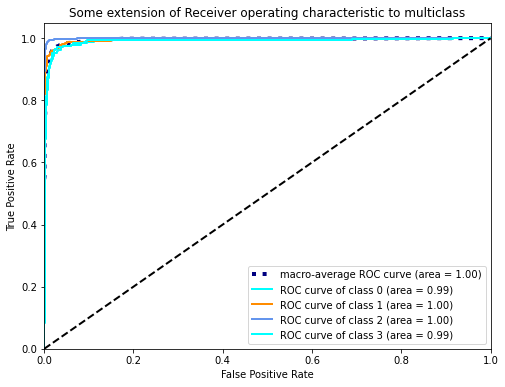

In [199]:
show_roc_auc(y_test_lbl, y_prob_bayes)

**Метрики получились лучше, чем при Градиентоном бустинге и методе Ближайших соседей, но метод так и не смог быть лучше Логистической Регрессии и метода Опорных векторов.**

## Brief Summary

In [197]:
methods = ['LogReg', 'KNN', 'Tree', 'Boosting', 'SVC', 'Bayes']
metrics = ['Accuracy', 'Recall', 'Precision', 'F-1']
predicted = [y_pred_lr, y_pred_knn, y_pred_tree, y_pred_gb, y_pred_svc, y_pred_bayes]
metrics_data = {}
for i in range(len(methods)):
    metrics_data = collect_data(metrics_data, y_test, predicted[i], methods[i])
df_metrics = pd.DataFrame.from_dict(metrics_data, orient='index', columns=metrics)
df_metrics

,Accuracy,Recall,Precision,F-1
LogReg,0.960384,0.960272,0.960288,0.960275
KNN,0.945378,0.945776,0.945453,0.945302
Tree,0.836735,0.837162,0.836892,0.836670
Boosting,0.945378,0.945275,0.945261,0.945245
SVC,0.962785,0.962693,0.962691,0.962687
Bayes,0.953181,0.953267,0.953154,0.953124


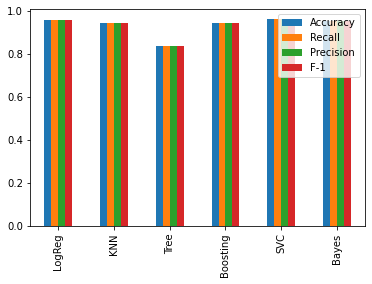

In [198]:
df_metrics.plot(kind='bar')
plt.show()

<i> В данной работе были рассмотрены 6 классификаторов машинного обучения для задачи классификации текста. Метрики почти на всех (кроме деревьев решений) получились достаточно высокими(>94%). Так же были наиболее значимые слова для различных категорий текстов. Лучшими оказались Логистическая Регрессия и Метод Опорных Векторов